# Init

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
#import btreceptor as bt 
%matplotlib inline
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotly
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")
sns.set_palette('colorblind')

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "../../figures/tcr_clonality/"
if not os.path.exists(output_dir):
            os.makedirs(output_dir)
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

### BtReceptor Edited for T cell data 

from __future__ import division
import pandas as pd
import numpy as np
import Levenshtein
from scipy.spatial.distance import squareform
from scipy.sparse.csgraph import connected_components
from itertools import combinations


def df_pw_edit(frame):
    """ Returns array of pairwise edit distances in square form """

    ed = np.zeros(int((frame.shape[0]/2)*(frame.shape[0]-1)), dtype='float')
    for c, (x, y) in enumerate(combinations(frame.cdr3.values, 2)):
        ed[c] = Levenshtein.distance(x, y) / np.max([len(x), len(y)])
    sq = squareform(ed)

    return sq


def df_lineages_from_subset(frame, similarity_cutoff):
    """ Returns an array of lineage membership based on a CDR3 cutoff """

    edit_sq = df_pw_edit(frame)

    n_groups, labels = connected_components(edit_sq <= round(1 - similarity_cutoff, 4))

    return labels


def df_add_lineages(dfin, similarity_cutoff):
    """ Returns input dataframe with additional lineage column
    Args:
        similarity_cutoff (float): e.g. 0.8 for 80% minimum cdr3aa similarity
    """

    dfin = dfin.copy()

    # unique index required for join
    if not dfin.index.is_unique:
        print("Input DataFrame index not unique, applying reset_index().")
        dfin.reset_index(drop=True, inplace=True)

    lincnt = 0
    lins = []

    for (v, j, _), sub in dfin.groupby(['v_call',
                                       'j_call',
                                       'cdr3nt_len']):
        if sub.shape[0] > 1:
            # CDR3 distance comparisoin
            sub_lineages = df_lineages_from_subset(sub, similarity_cutoff)
            lins += zip(sub.index, sub_lineages + lincnt)
            lincnt += np.unique(sub_lineages).shape[0]
        else:
            # single sequence belongs in its own lineage
            lins.append((sub.index.values[0], lincnt))
            lincnt += 1

    # adds a "lineage" column corresponding to the lineage number for that cell
    lins = pd.DataFrame(lins, columns=['index', 'lineage']).set_index('index')
    if 'lineage' in dfin.columns:
        dfin = dfin.drop('lineage', axis=1).join(lins)
    else:
        dfin = dfin.join(lins)

    return dfin


def donor_colors():
    donors = ['TSP1','TSP2','TSP3','TSP4','TSP5','TSP6','TSP7','TSP8','TSP9','TSP10','TSP11','TSP12','TSP13','TSP14','TSP15']
    
    import matplotlib.colors as pltcolors
    
    cmap = plt.cm.get_cmap("YlGnBu")
        
    donor_color_dict = {}
    j=1/len(donors)
    for d in donors:
        donor_color_dict[d] = pltcolors.to_hex(cmap(j))
        j+=1/len(donors)
        
    return donor_color_dict


def donor_colors():
    donor_color_dict = {'TSP6': '#034001', 'TSP7': '#8FBC8F', 'TSP4': '#c5ba30', 'TSP5': '#DC143C', 
                    'TSP10': '#FFD700', 'TSP8': '#8839ff', 'TSP3': '#c34a17', 'TSP11': '#00edff', 
                    'TSP12': '#f507a0', 'TSP9': '#9CADCA', 'TSP14': '#27BFD2', 'TSP15': '#bc7c00', 
                    'TSP1': '#4169E1', 'TSP2': '#636c8c', 'TSP13': '#ADD8E6'}
    return donor_color_dict

from numpy.random import seed


def df_generate_node_dict(frame, singletons=False):
    """ Generates a node property dictionary for downstream graph-tool plotting
        Args:
            frame (pd.Dataframe) with the following columns:
                - lineage (mandatory)
                - node_color (optional)
                - node_shape (optional)
                - node_size (optional)
                - node_stroke (optional)
            singletons (bool): whether to include cells that do not form
                multi-member clonal families
        Returns:
            dict: nested as follows: {node_id: {'property1': 'value1', ...}}
    """
    frame = frame.copy()

    # use some defaults if property columns are missing
    req_key_defaults = {'node_color': 'blue',
                        'node_shape': 'circle',
                        'node_size': 0.05,
                        'node_stroke': 0.1}
    for key, default in req_key_defaults.items():
        if key not in frame.columns:
            frame[key] = default  # add column to dataframe

    node_props = {}
    node_id = 0
    for lin, g in frame.groupby('lineage'):
        if g.shape[0] > 1 or singletons:
            if g.shape[0] > 1:
                # add a germline to root all cells in a lineage
                gid = node_id
                node_props[gid] = {'color': 'k',
                                   'ancestor': None,
                                   'size': frame['node_size'].min(),
                                   'shape': 'circle',
                                   'stroke': 0}
                node_id += 1
            else:
                # no germline root for a singleton
                gid = None

            # add cell(s) with properties
            for _, row in g.iterrows():
                node_props[node_id] = {'ancestor': gid,
                                       'color': row['node_color'],
                                       'shape': row['node_shape'],
                                       'size': row['node_size'],
                                       'stroke': row['node_stroke']
                                       }
                node_id += 1

    return node_props


def draw_gviz(node_dict, size_multiple=50, random_seed=42, **kwargs):
    """ Draw clonal network using graph-tool
    More information: graphtool edge / vertex parameters and examples:
        https://graph-tool.skewed.de/static/doc/draw.html#graph_tool.draw.graph_draw
        http://ryancompton.net/2014/10/05/graph-tools-visualization-is-pretty-good/
    Args:
        node_dict (dict): nested dictionary of node properties
            Generate this using df_generate_node_dict()
        size_multiple (int): scaling factor for node size (for convenience)
        **kwargs: keyword arguments passed to gt.graph-draw()
            e.g. output='file.pdf', layout='neato', output_size=(300,300)
    """
    import graph_tool.all as gt

    g = gt.Graph()
    vsizes = g.new_vertex_property("int")
    vcolors = g.new_vertex_property('string')
    vshapes = g.new_vertex_property('string')
    vpenwidth = g.new_vertex_property("float")  # stroke

    for node_id, node_props in node_dict.items():
        g.add_vertex()

        vshapes[g.vertex(node_id)] = node_props['shape']
        vcolors[g.vertex(node_id)] = node_props['color']
        vsizes[g.vertex(node_id)] = node_props['size']*size_multiple
        vpenwidth[g.vertex(node_id)] = node_props['stroke']

        # add edge to ancestor
        if node_props['ancestor'] is not None:
            g.add_edge(node_props['ancestor'], node_id)

    # seeds enable graph reproduction
    seed(random_seed)
    gt.seed_rng(random_seed)

    gt.graph_draw(g,
                  vertex_size=vsizes,
                  vertex_fill_color=vcolors,
                  vertex_shape=vshapes,
                  vertex_pen_width=vpenwidth,
                  vertex_color='k',  # stroke color
                  bg_color=[1, 1, 1, 1],  # white
                  edge_end_marker='none',
                  **kwargs)
    
    
# visualize the color dictionaries
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    by_hsv = [(v, k) for k, v in colors.items()]
    
    if sort_colors is True:
        by_hsv = sorted(by_hsv)
    names = [name for hsv, name in by_hsv]

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)

    return fig

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        print(idx, colorNum)
        colorList = colorList + [colorPalette[idx]]*colorNum
        print(colorList)
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [4]:
df = pd.read_table('../../data/merged_airr.tsv')


print(df.method.value_counts())


df = df[df.locus.str.contains('TRA')]

df['cdr3nt_len'] = df.cdr3.str.len()


df = df_add_lineages(df, similarity_cutoff=0.8)

df['node_color'] = df.donor.map(donor_colors())

df.groupby('donor').tissue.value_counts()



smartseq2    10309
10X            492
Name: method, dtype: int64


donor  tissue        
TSP1   Muscle             79
       Blood              54
       Lung               35
       Pancreas            2
TSP10  Fat               111
       Skin               39
TSP11  Bone_Marrow       260
TSP13  Bone_Marrow        41
TSP2   Lymph_Node        766
       Blood             488
       Bone_Marrow       479
       Spleen            304
       Muscle            210
       Skin              156
       Kidney            110
       Vasculature        24
       Bladder            16
       Lung                4
       Thymus              2
TSP3   Eye                 8
TSP4   Muscle            166
       Mammary           114
       Uterus             54
TSP5   Eye                24
TSP6   Liver               3
       Trachea             1
TSP7   Lymph_Node        338
       Salivary_Gland    180
       Spleen            177
       Tongue            106
       Blood              59
TSP8   Prostate           32
TSP9   Pancreas            5
Name: tissue, dtype: 

## Graphs

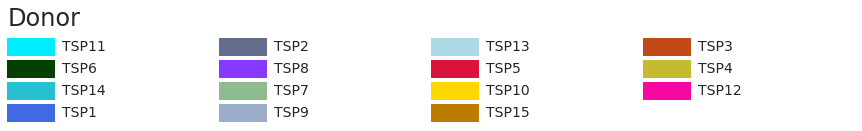

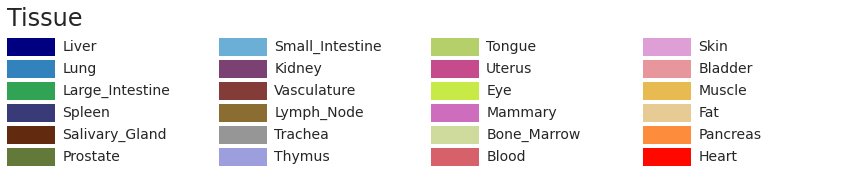

In [5]:
node_dict = df_generate_node_dict(df)

draw_gviz(node_dict, random_seed=1, output = output_dir + 'TCR_colorby_Donor_Graph.pdf')
fig = plot_colortable(colors=donor_colors(), title='Donor')
fig.savefig(output_dir + 'donor_legend.pdf')

df['node_color'] = df.tissue.map(tissue_colors())

node_dict = df_generate_node_dict(df)

draw_gviz(node_dict, random_seed=1, output = output_dir +'TCR_colorbyTissue_Graph.pdf')
fig = plot_colortable(colors=tissue_colors(), title='Tissue')
fig.savefig(output_dir + 'tissue_legend.pdf')



## Rename Clones from numbers to letters

In [77]:
# this is to name them alphabetically bc there are currently too many
selector = df.lineage.value_counts()
selector = selector[selector > 1].index
df = df[df.lineage.isin(selector)]

import string
def listAlphabet():
  return list(string.ascii_lowercase)

#rename_lineages = dict(zip(df.lineage.unique(), listAlphabet()))

In [11]:
df.loc[:,'lineage'] = df.lineage.map(rename_lineages)

## Sankey

In [12]:

import plotly
import plotly.graph_objects as go
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        print(idx, colorNum)
        colorList = colorList + [colorPalette[idx]]*colorNum
        print(colorList)
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [13]:
selector = df.lineage.value_counts() > 5

lineages = selector[selector == True].index

df_lineages = df[df.lineage.isin(lineages)]
#df_lineages = df_lineages[~df_lineages.tissue.isin(['Fat', 'Heart', 'Skin'])]

forSankey = df_lineages.groupby(['lineage', 'cell_ontology_class']).tissue.value_counts()

forSankey = pd.DataFrame(forSankey)

forSankey.columns = ['counts']

forSankey.reset_index(inplace = True)

forSankey.tissue = forSankey.tissue.str.replace('BM', 'Bone_Marrow')

forSankey.tissue = forSankey.tissue.str.replace('LymphNode', 'Lymph_Node')

fig = genSankey(forSankey, cat_cols=['tissue', 'lineage', 'cell_ontology_class'],
                value_cols='counts', 
                title='')

0 13
['#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE']
1 21
['#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998']
2 16
['#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#F

In [14]:
import plotly.express as px

#cell_type_colors = dict(zip(list(df_lineages.my_leiden.unique()), px.colors.qualitative.Dark24[:]))
cell_type_colors = dict(zip(list(df_lineages.cell_ontology_class.unique()), px.colors.qualitative.Dark24[:]))

# Increase the font size
fig['layout']['font']['size'] = 18
# Update colors to be the TS colors
_num_tissues = df_lineages.tissue.unique().shape[0]
_num_lineages = df_lineages.lineage.unique().shape[0]
# Breaks if there are too many lineages involved
_dict = dict(zip(list(df_lineages.lineage.unique()), px.colors.qualitative.Alphabet[:]))

_dict.update(tissue_colors())
_dict.update(cell_type_colors)

# create color list according to color dictionary
old_dict = dict(zip(fig['data'][0]['node']['label'], fig['data'][0]['node']['color']))


new_dict = {key: _dict[key] for key, value in old_dict.items()}

fig['data'][0]['node']['color'] = list(new_dict.values())

In [19]:
plotly.offline.plot(fig, image_height=1000, image_width=1000, validate=False, image='png', image_filename="T_Cell_Sankey")

'temp-plot.html'

## counting multi-tissue clones 

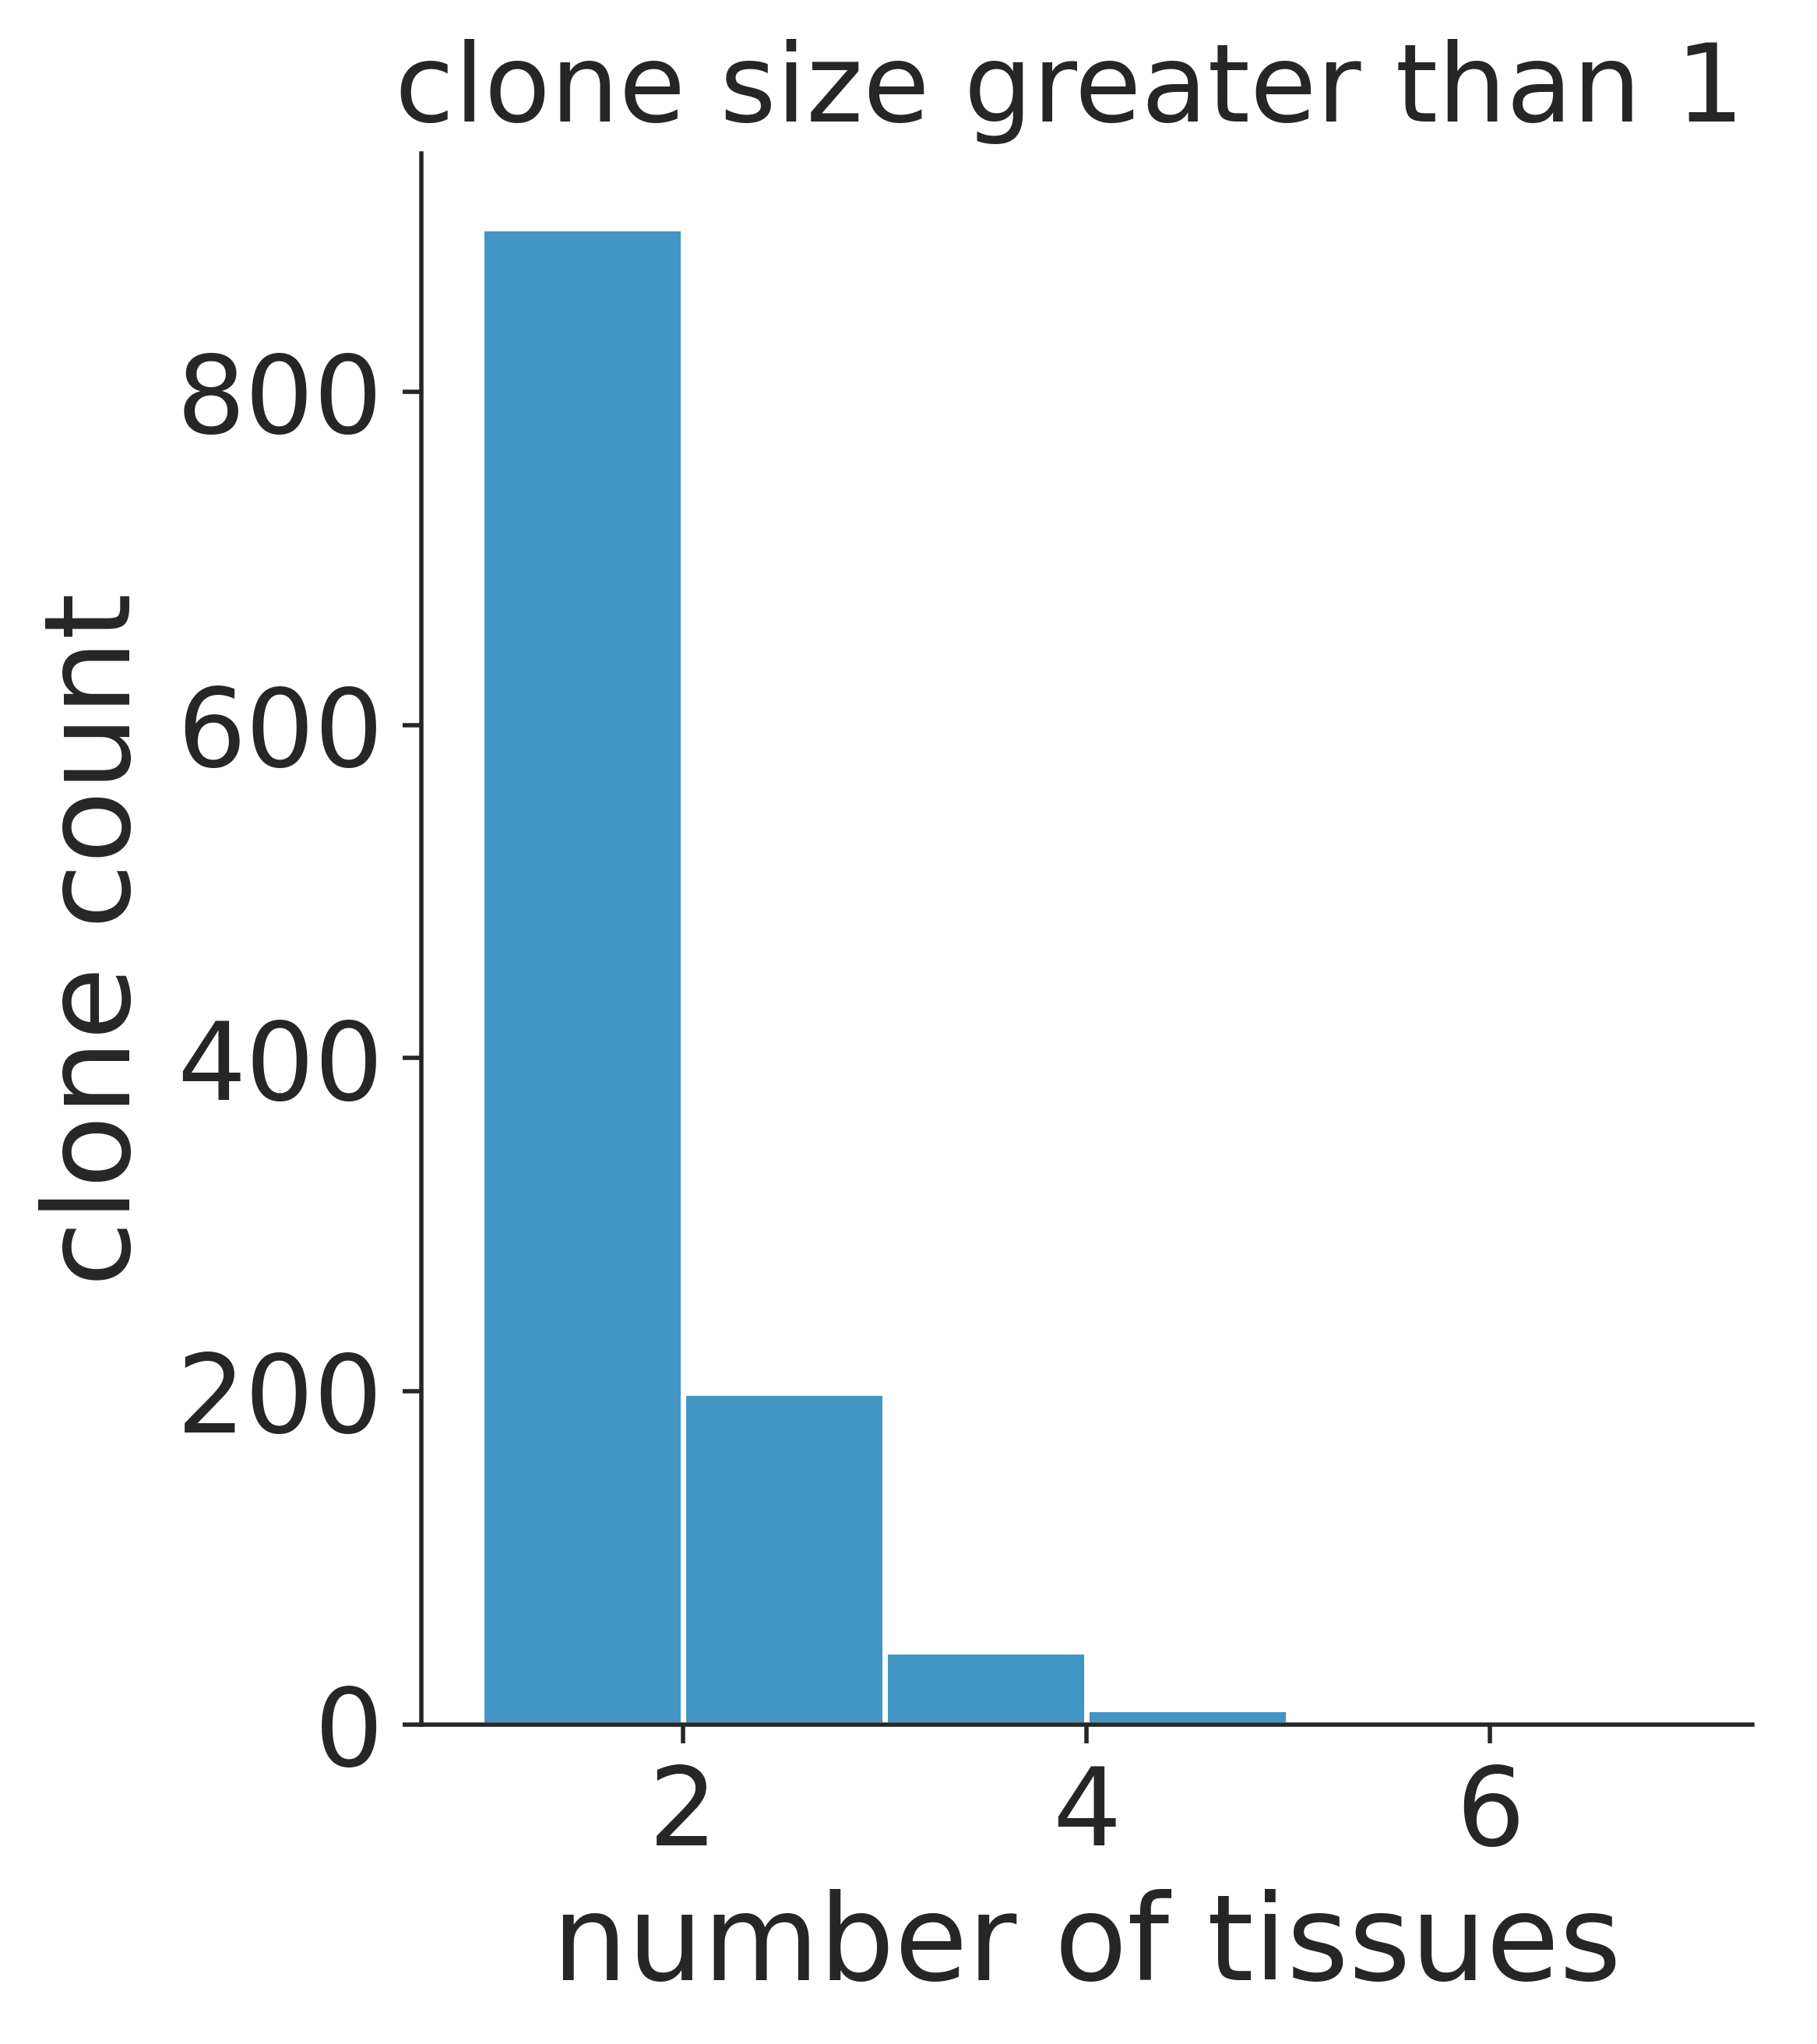

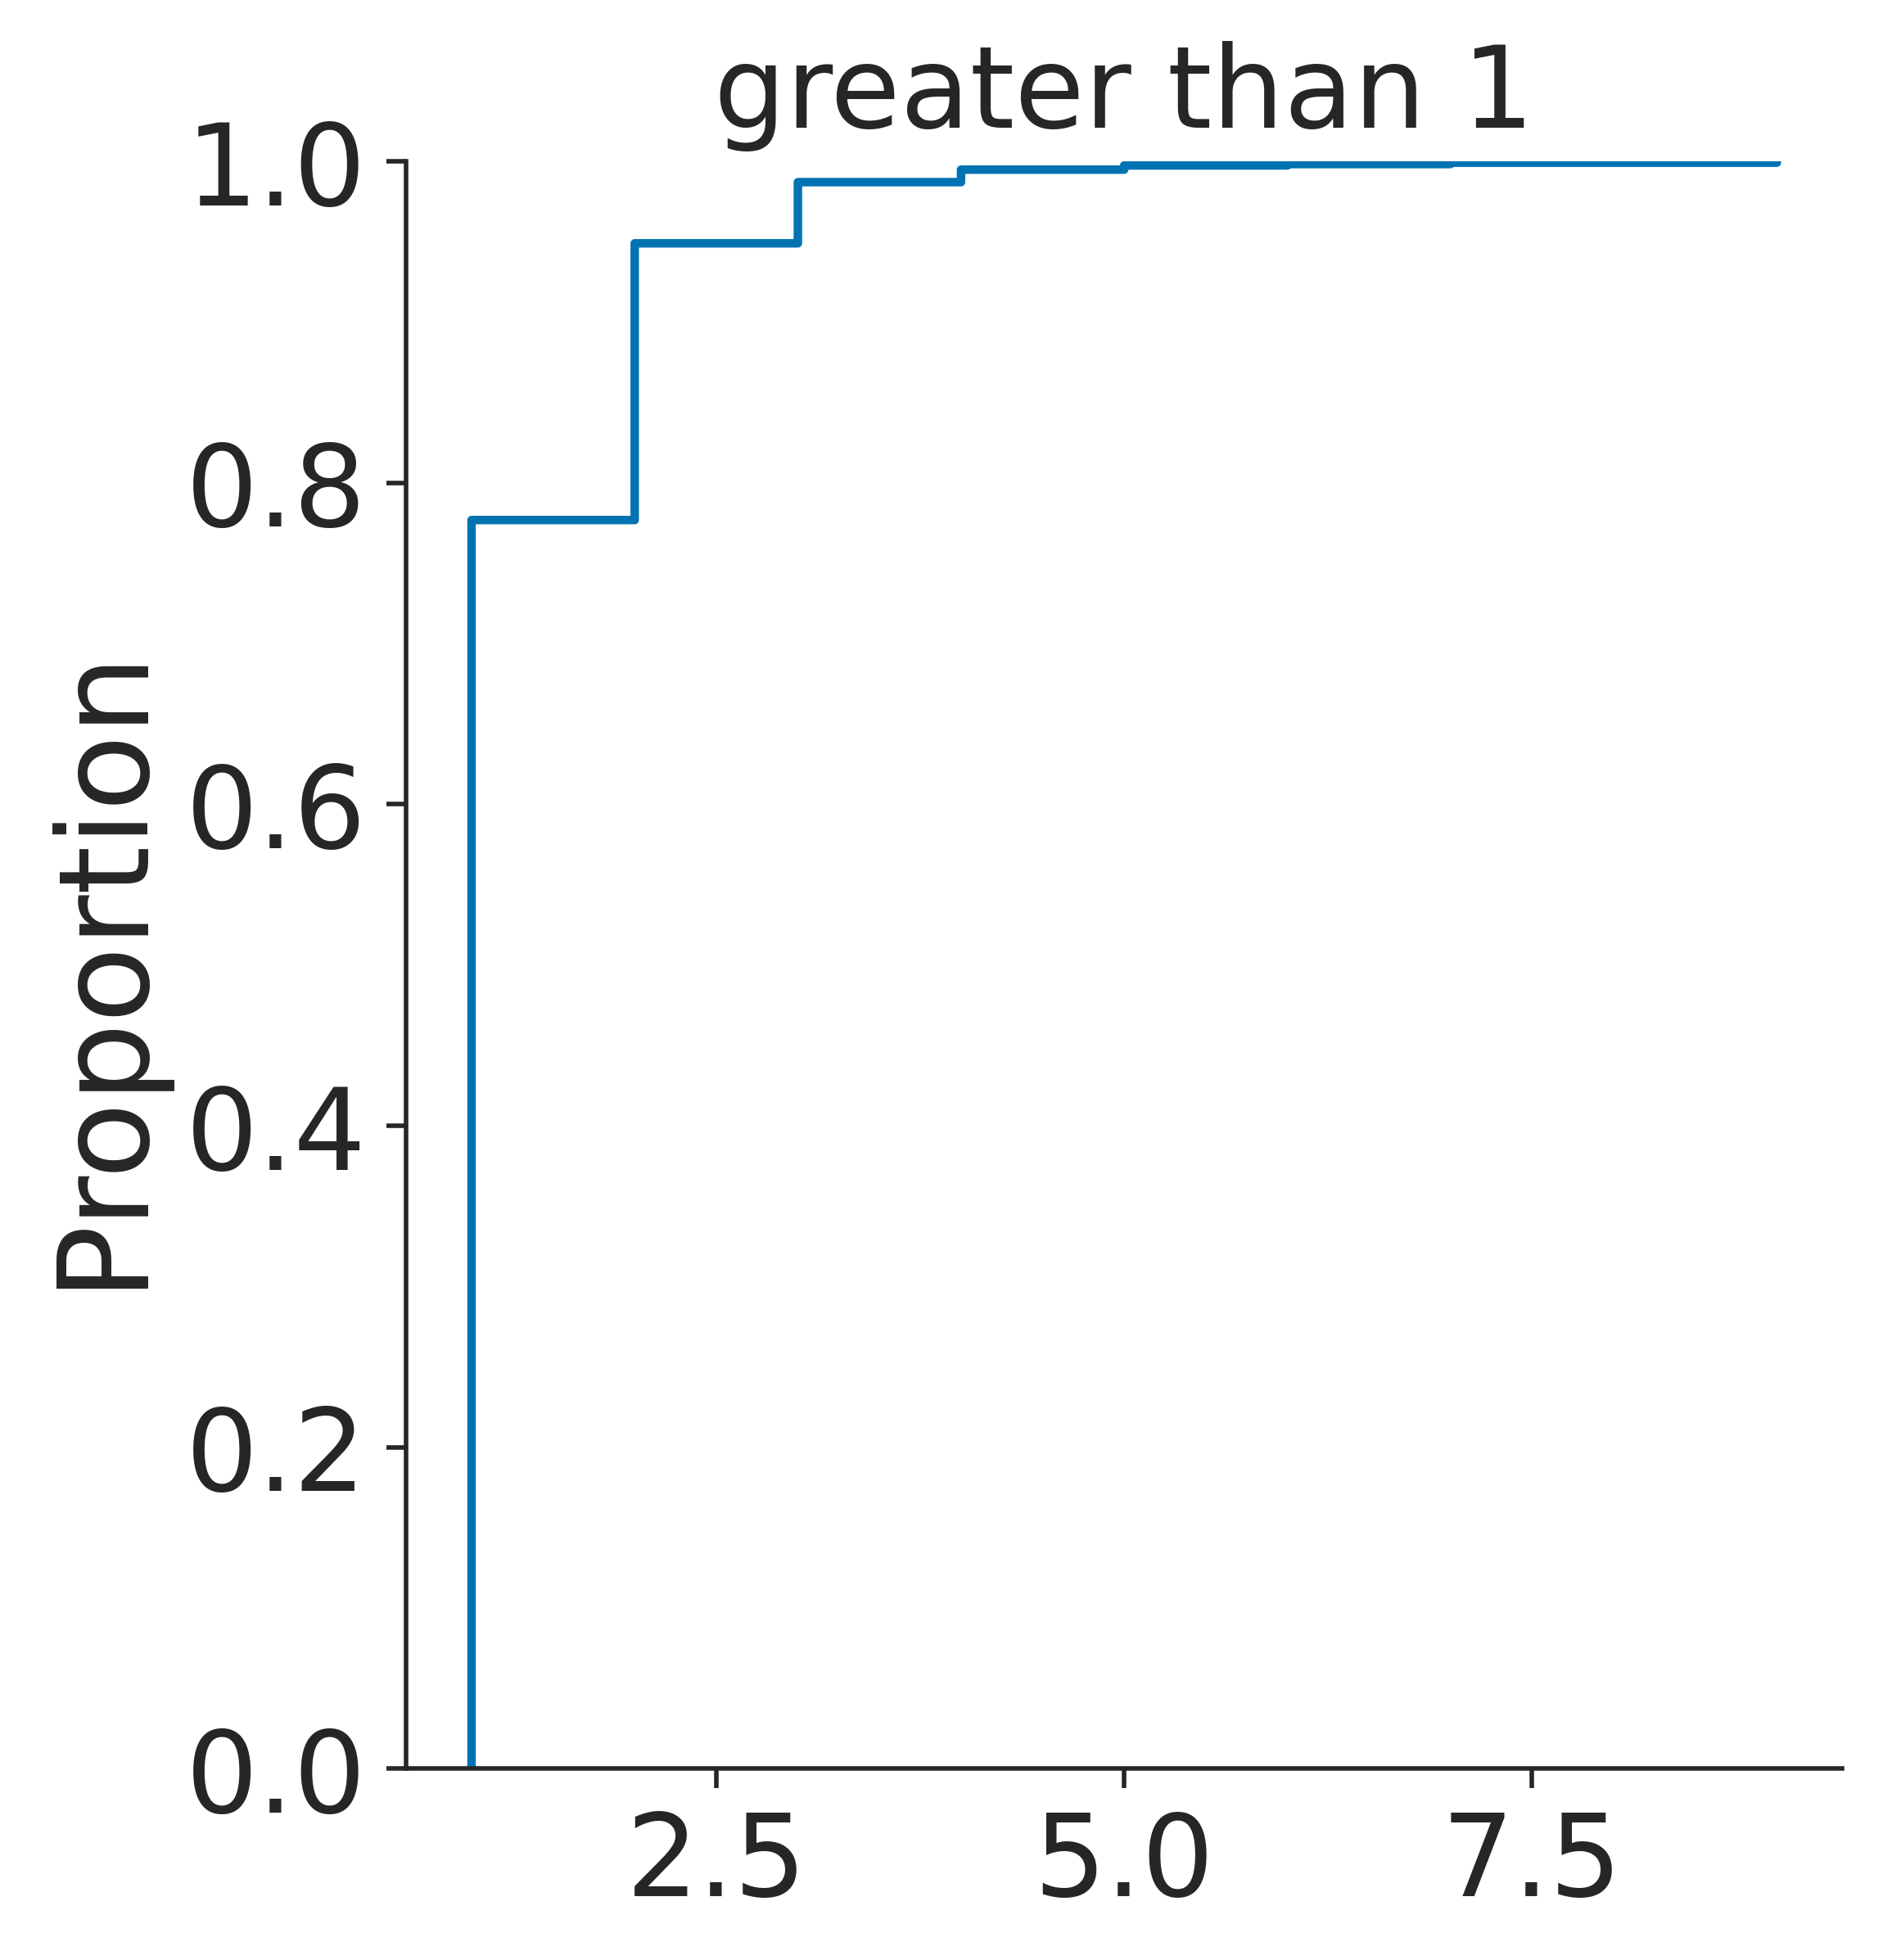

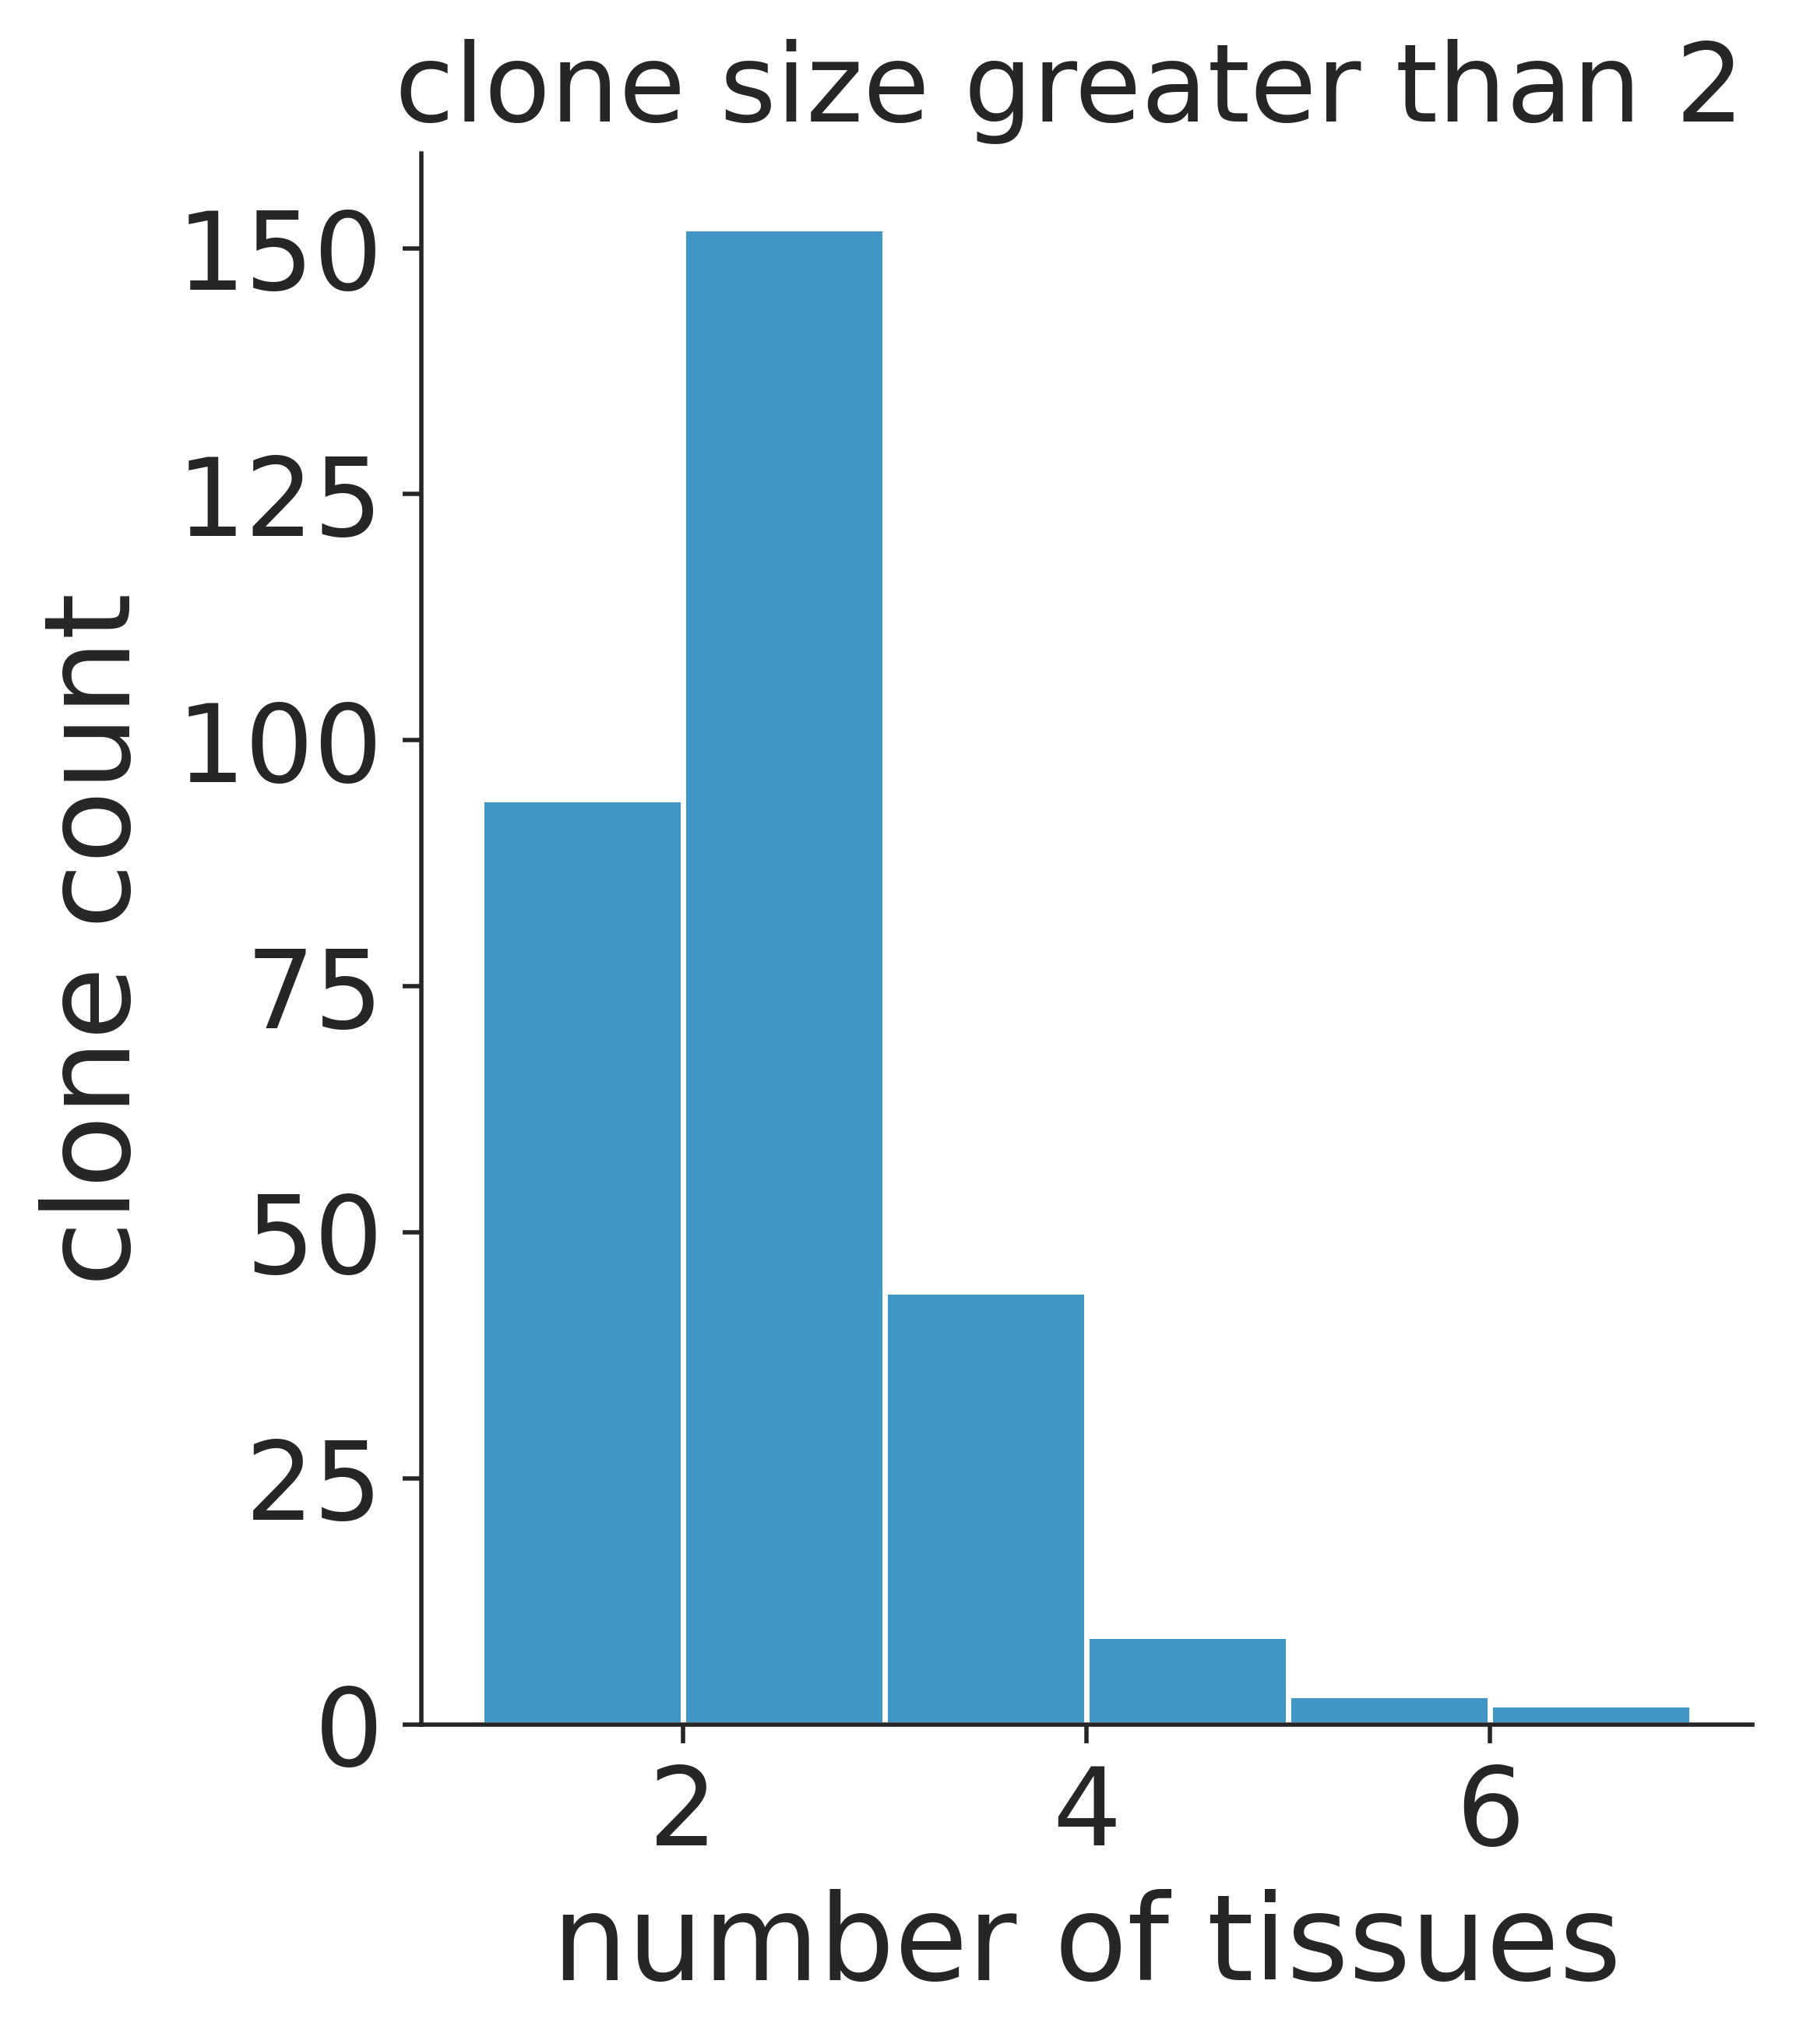

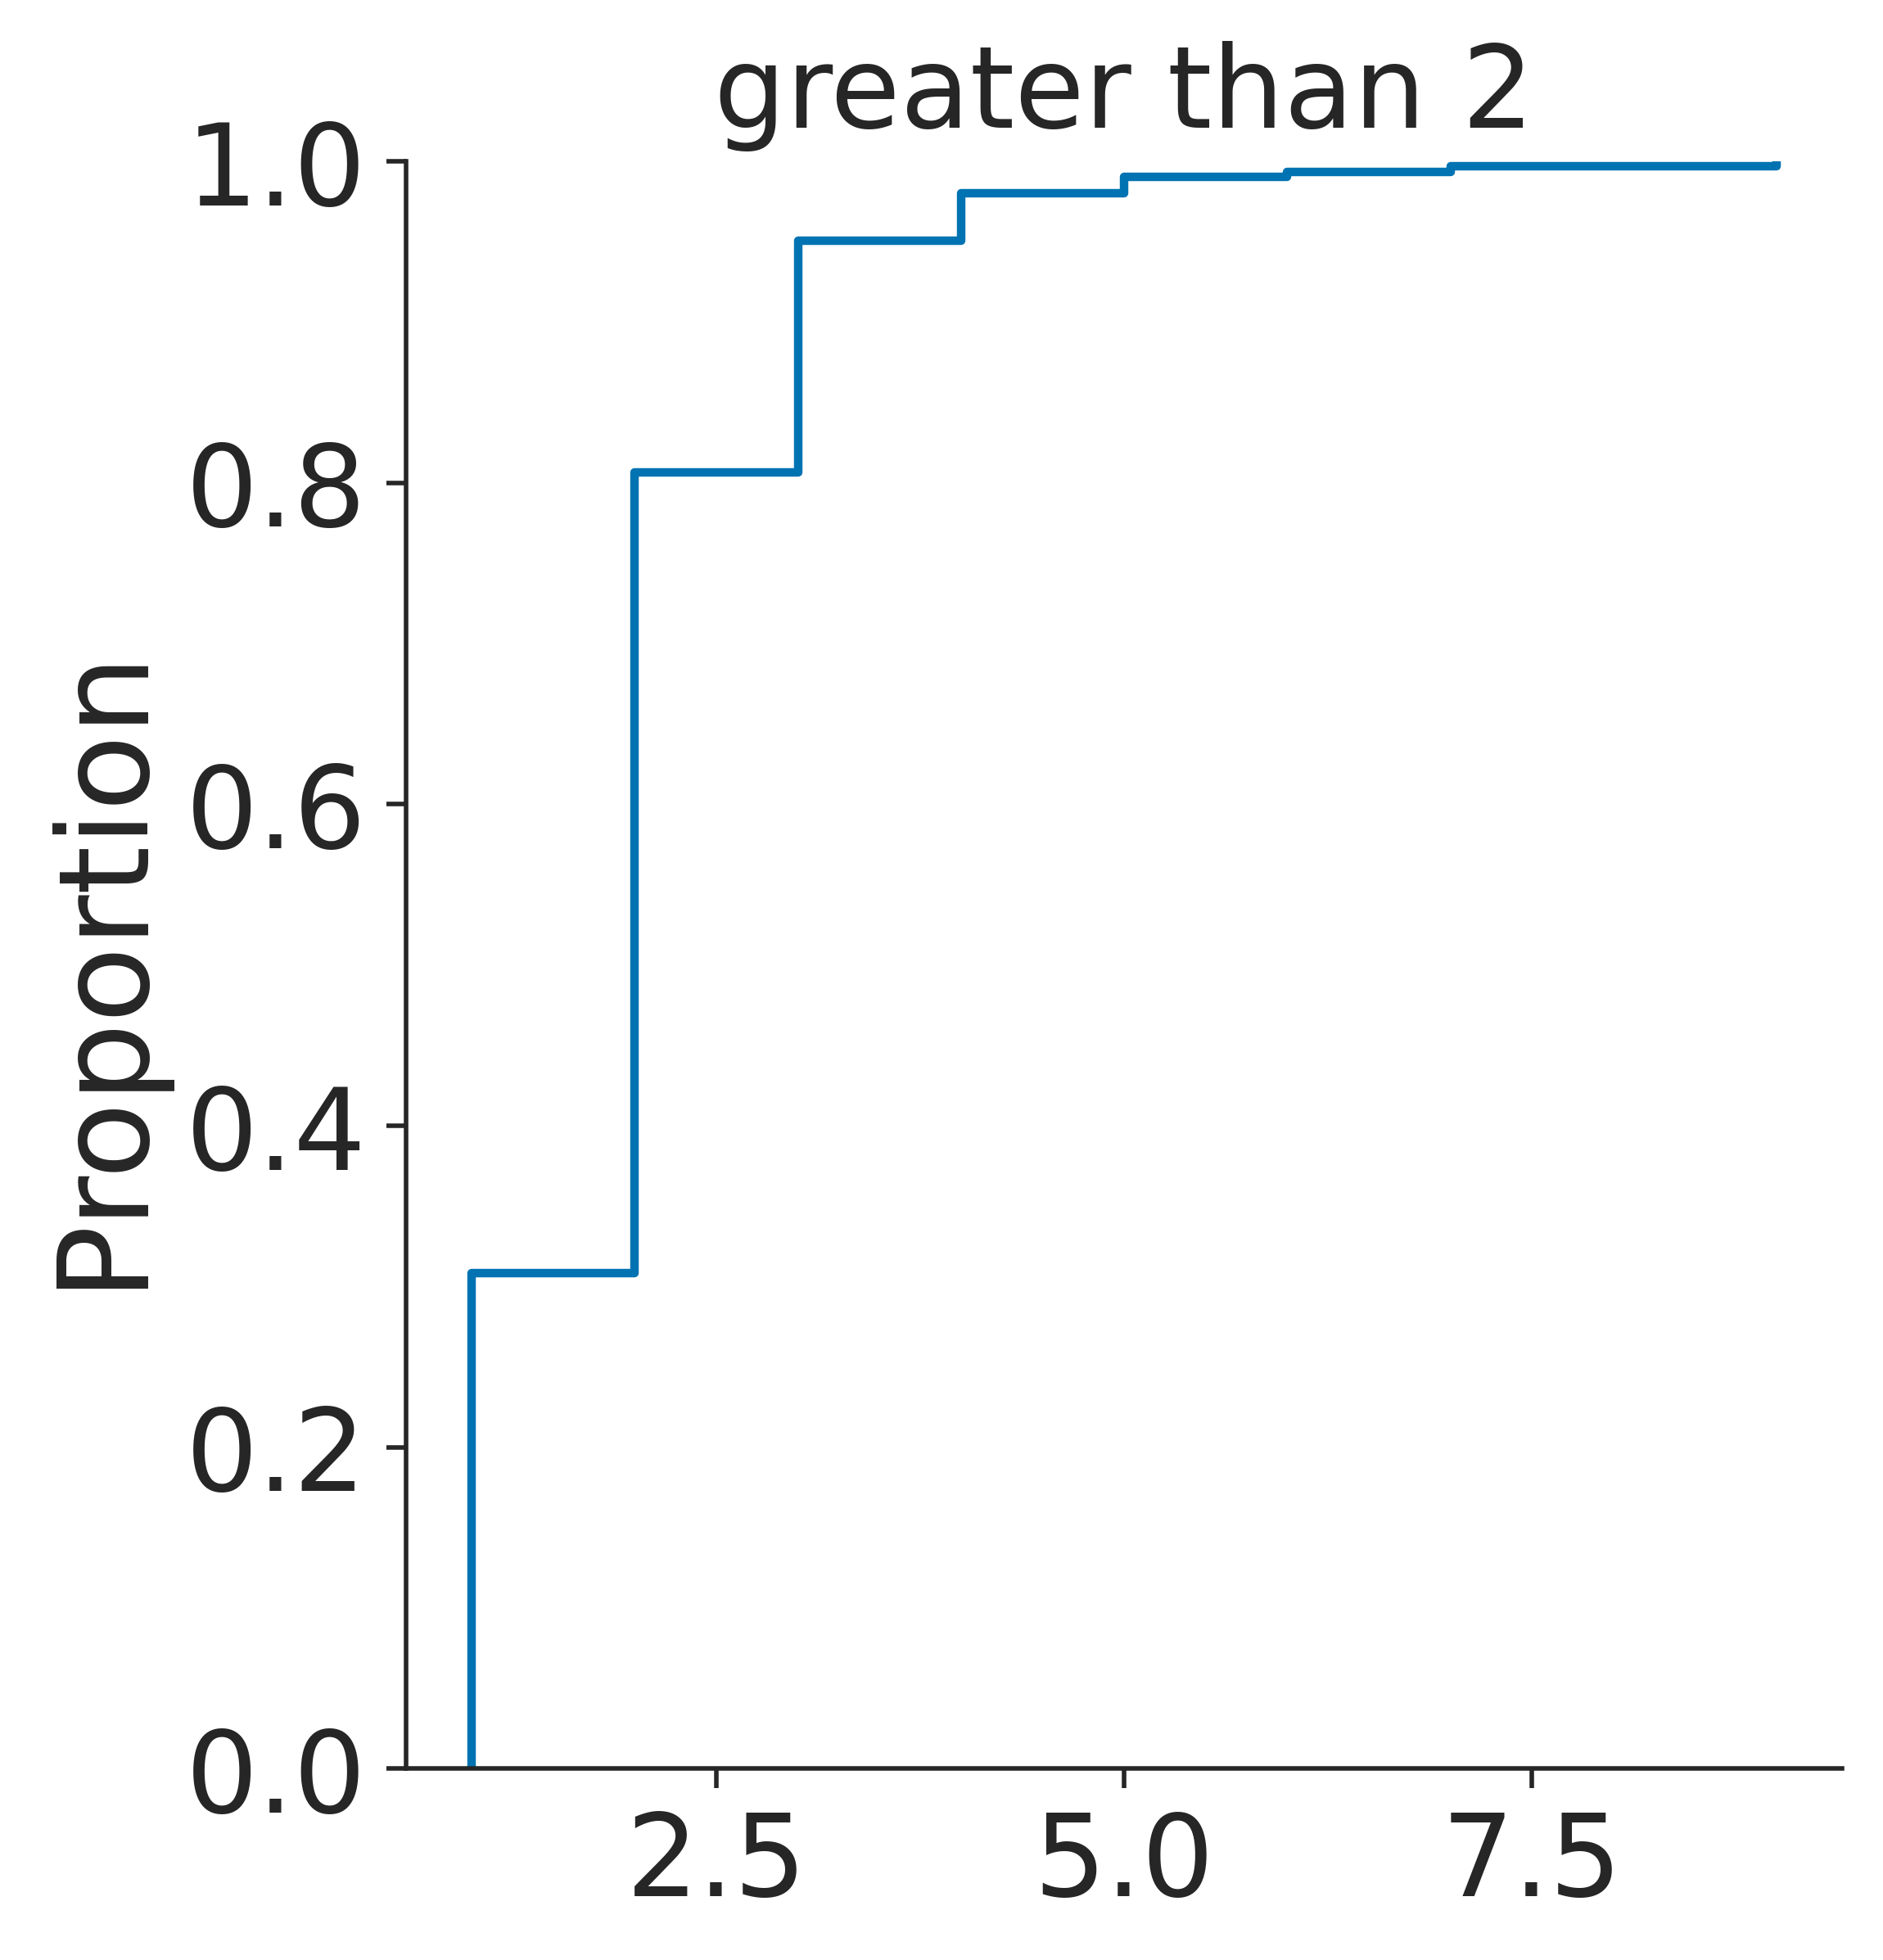

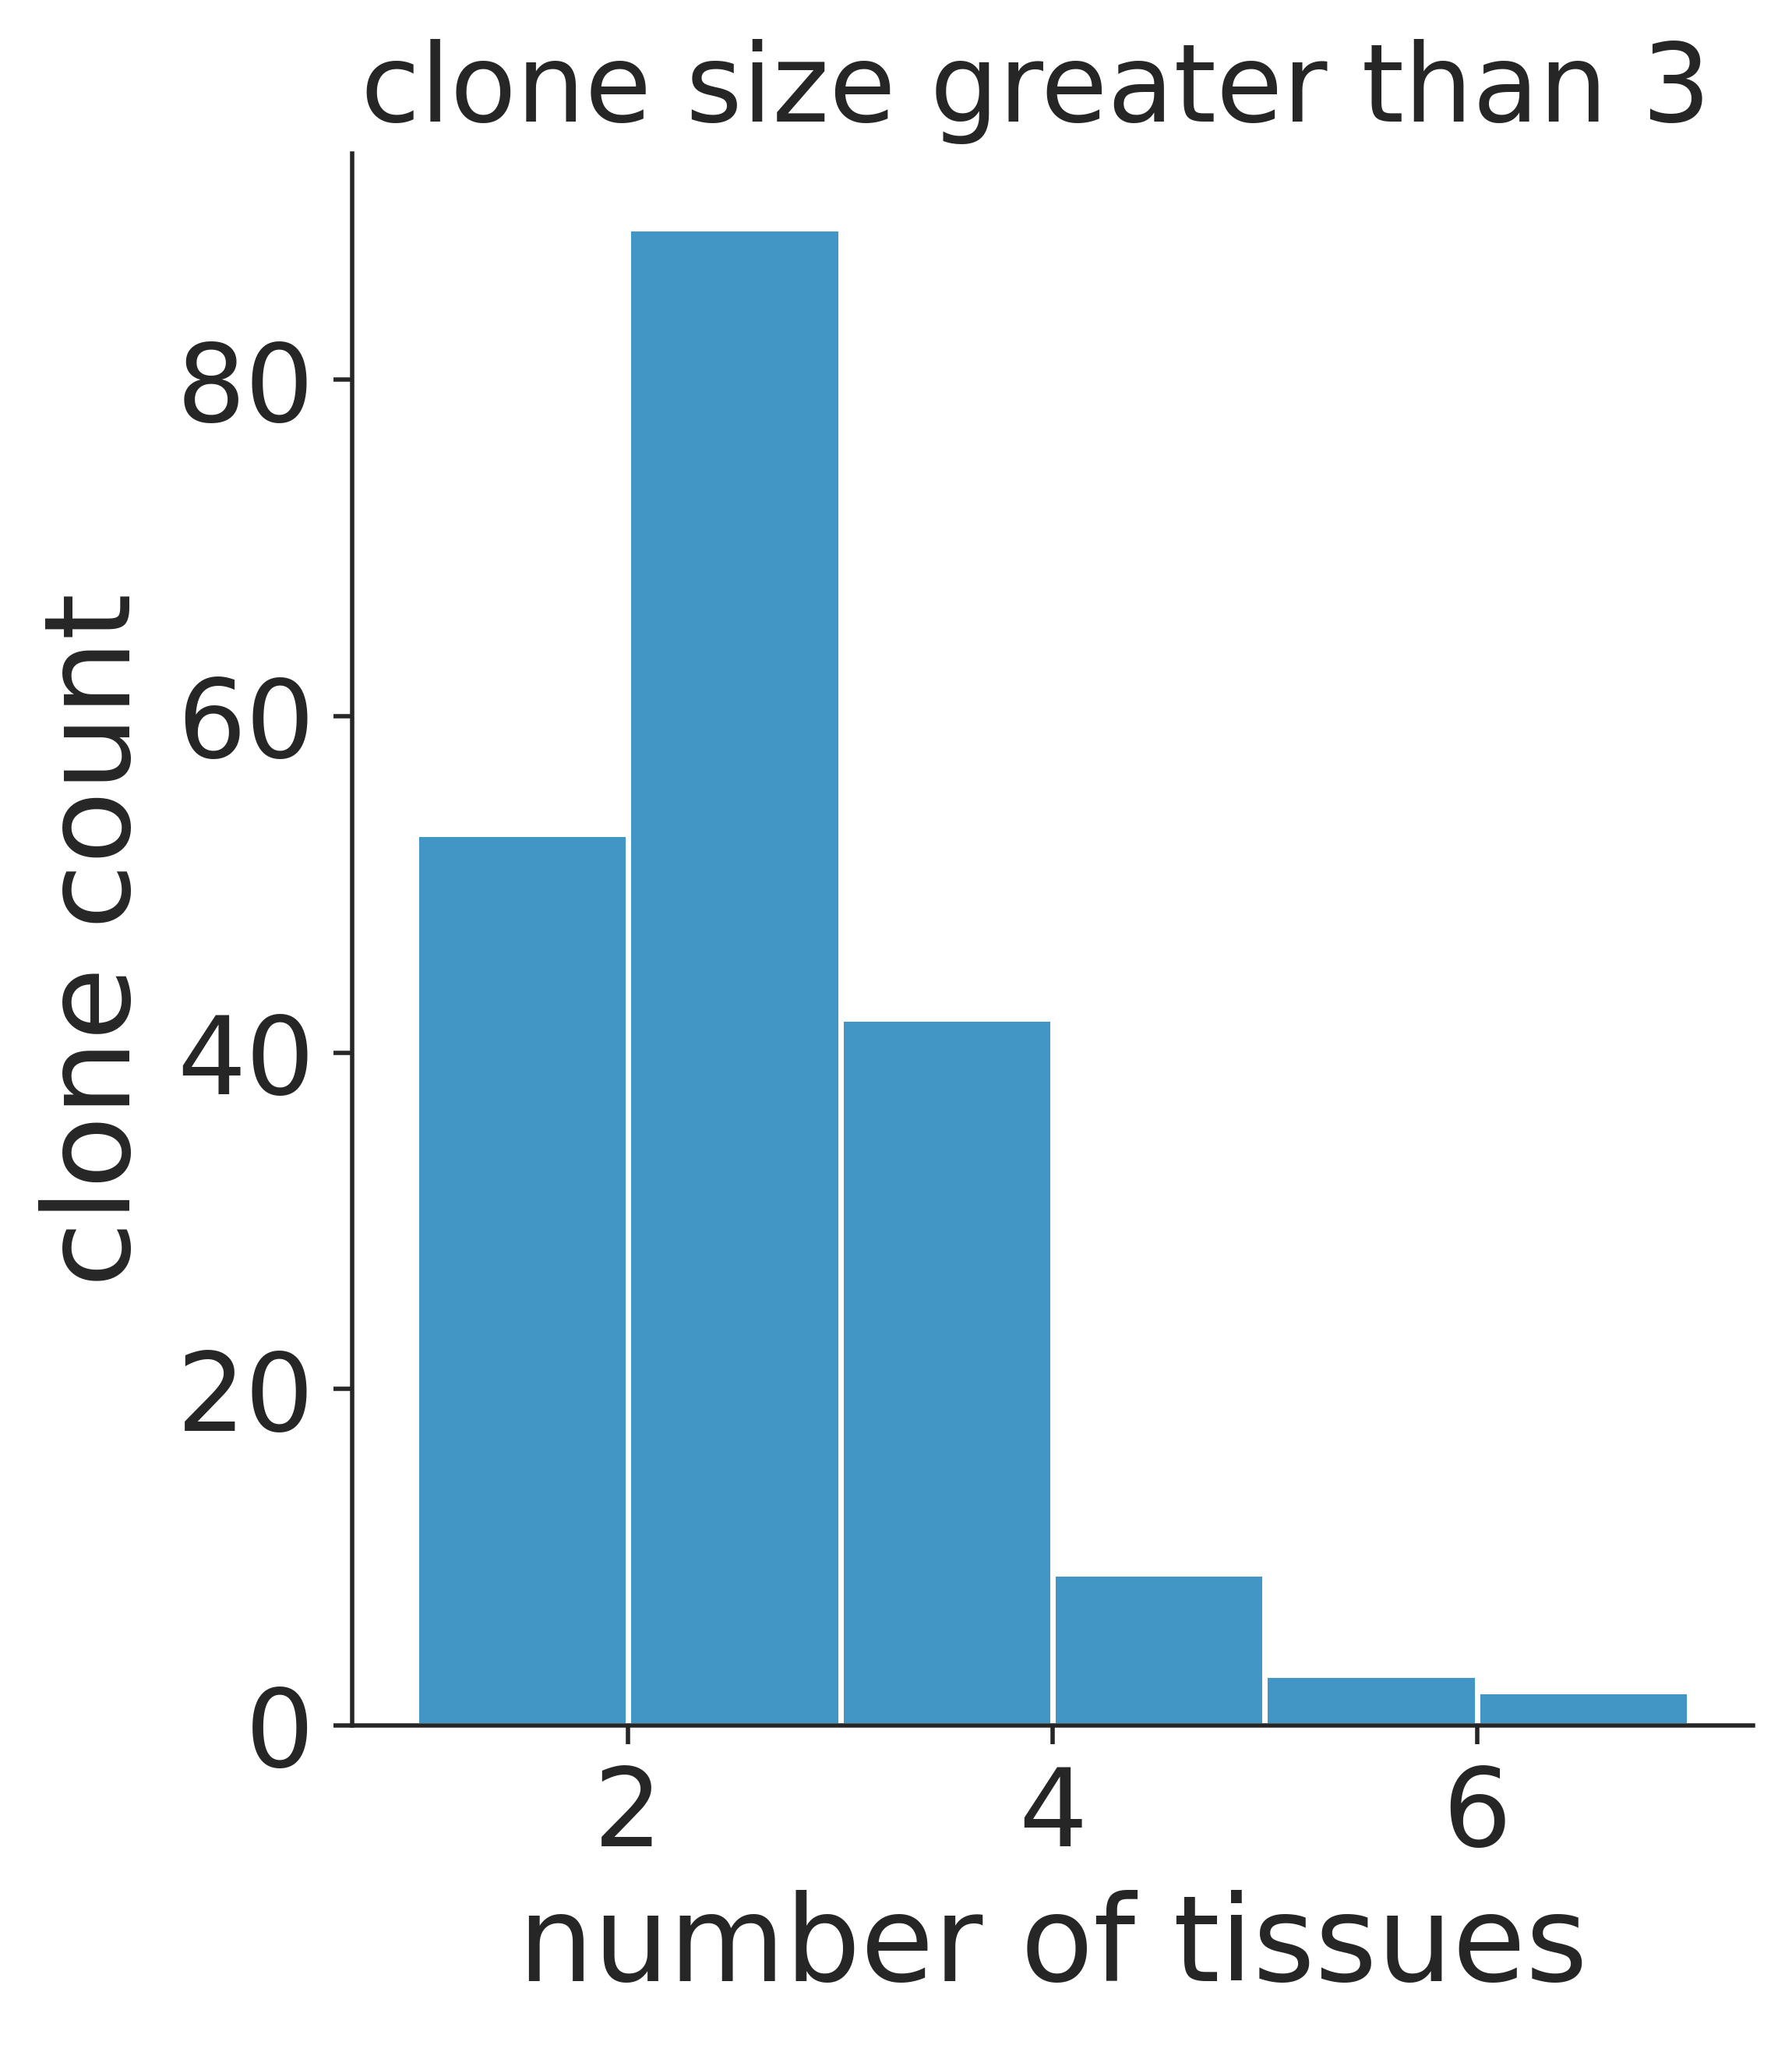

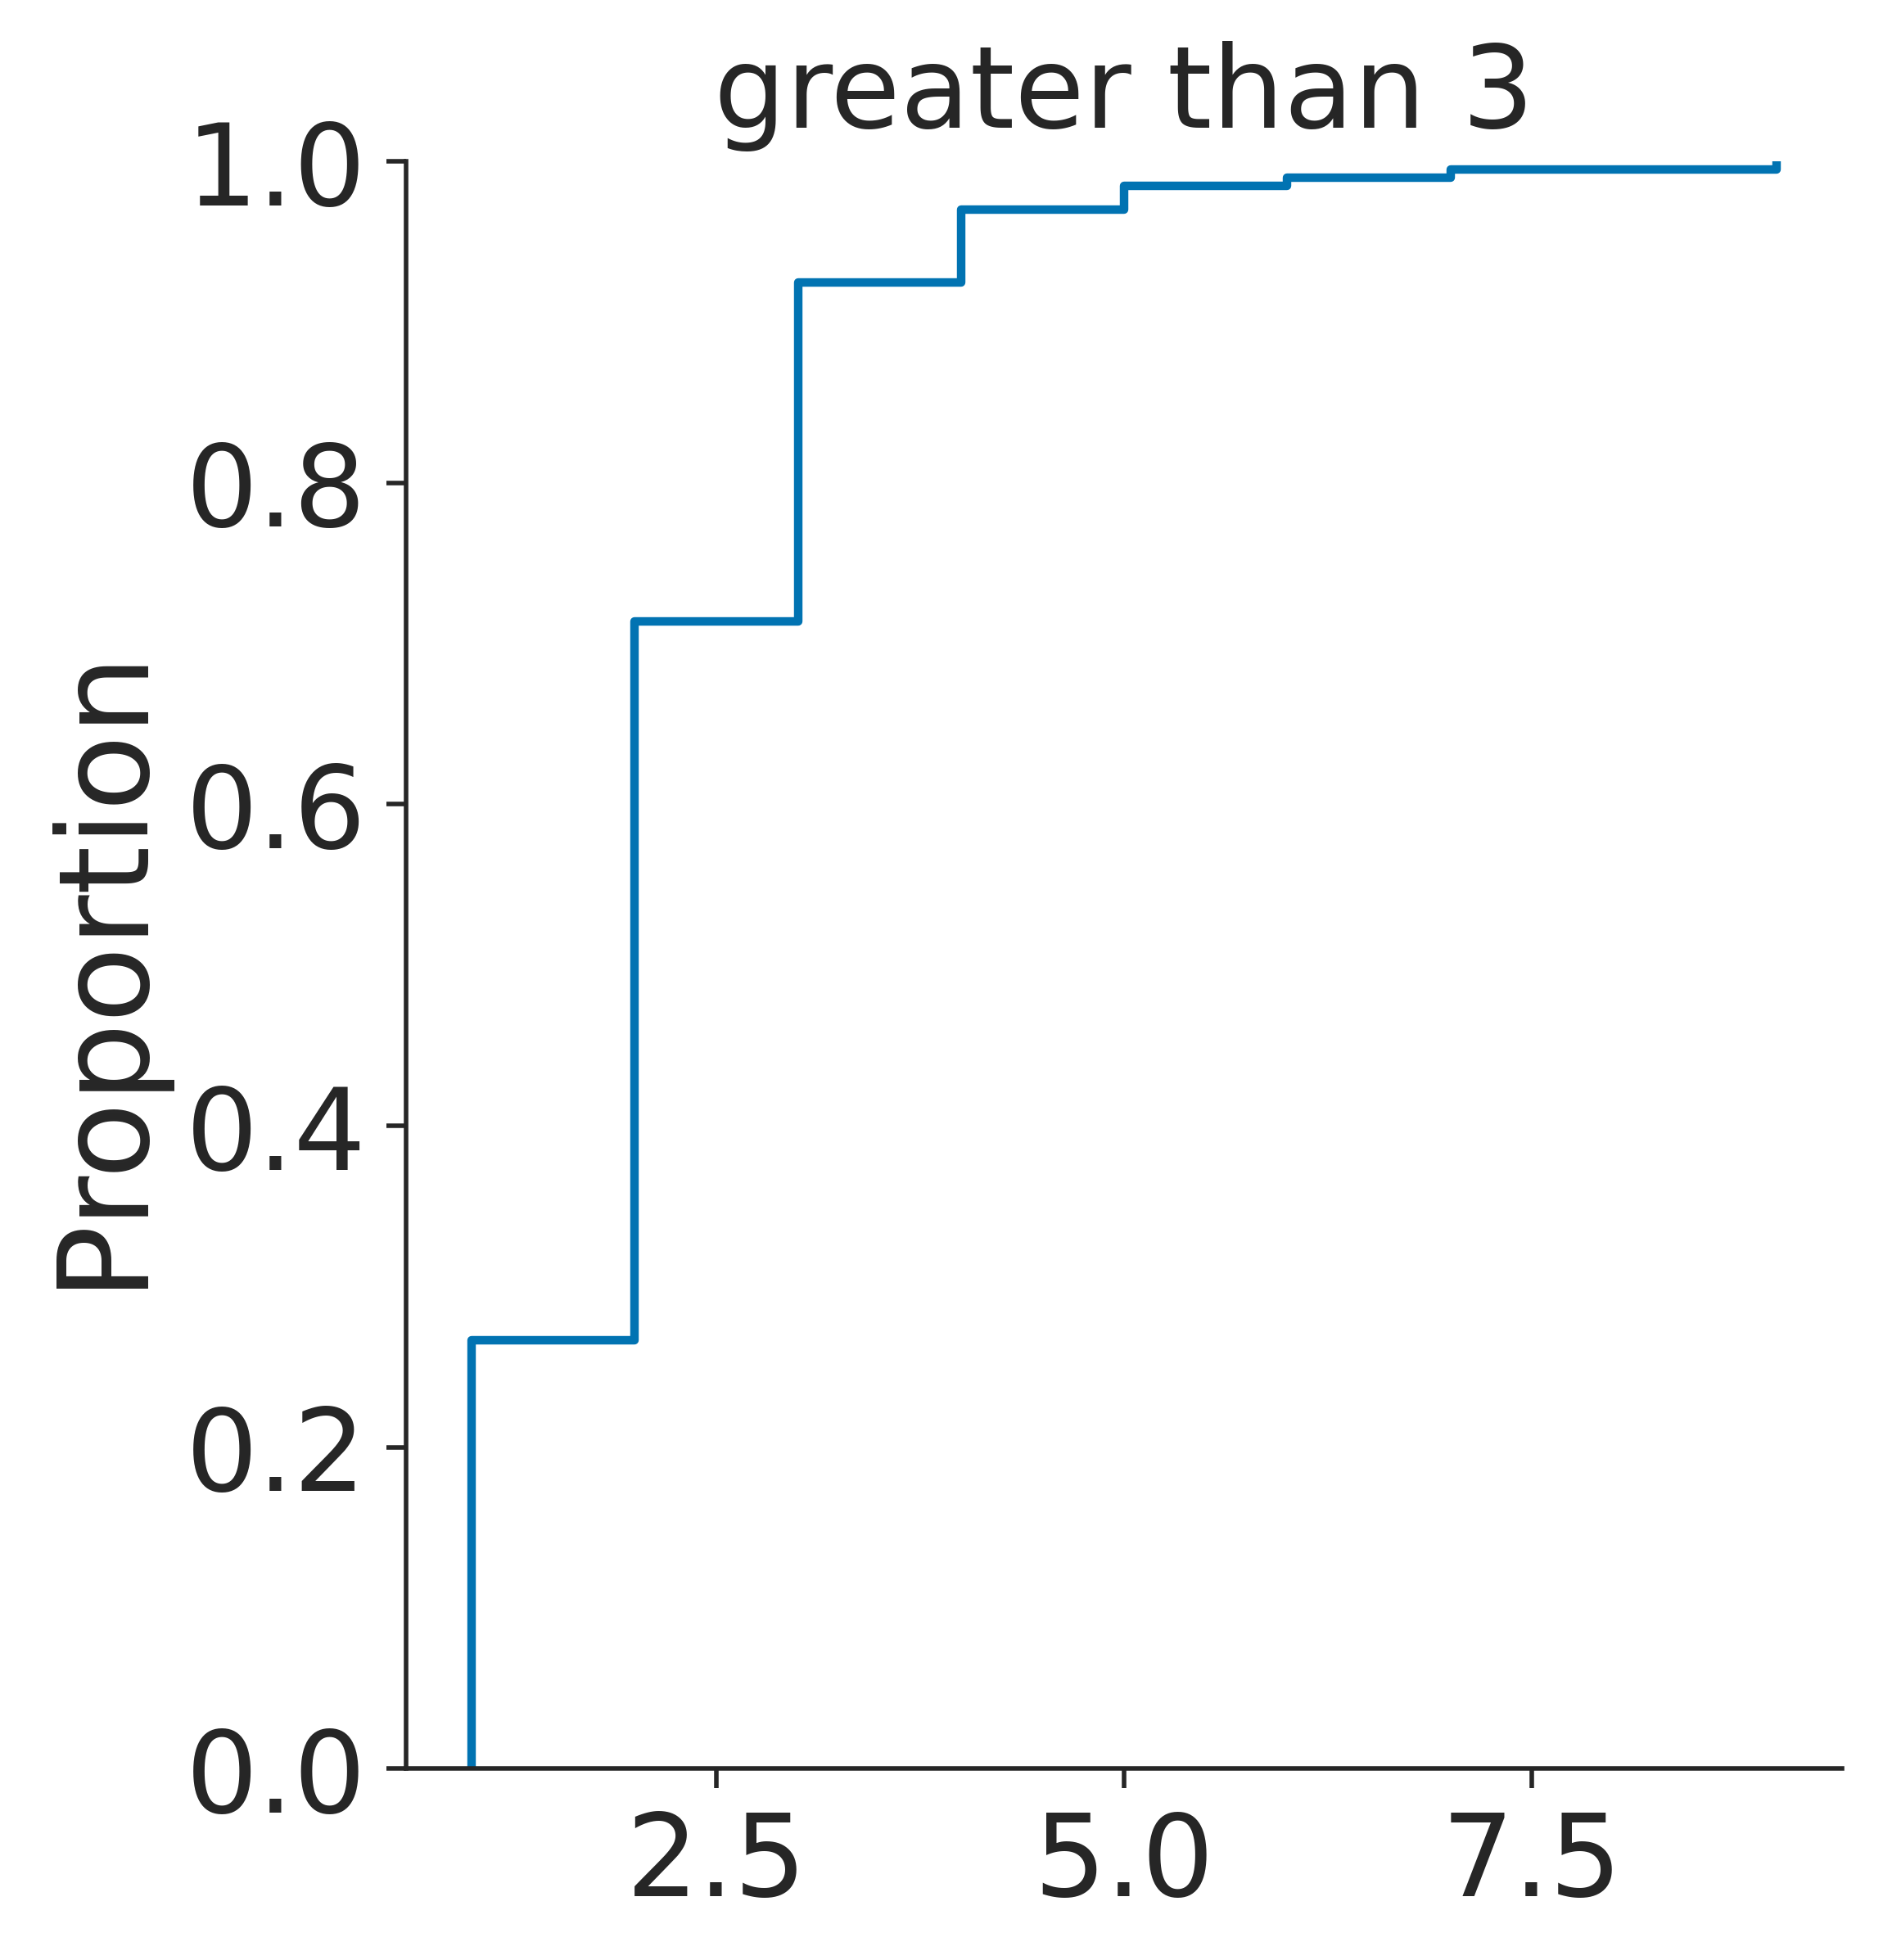

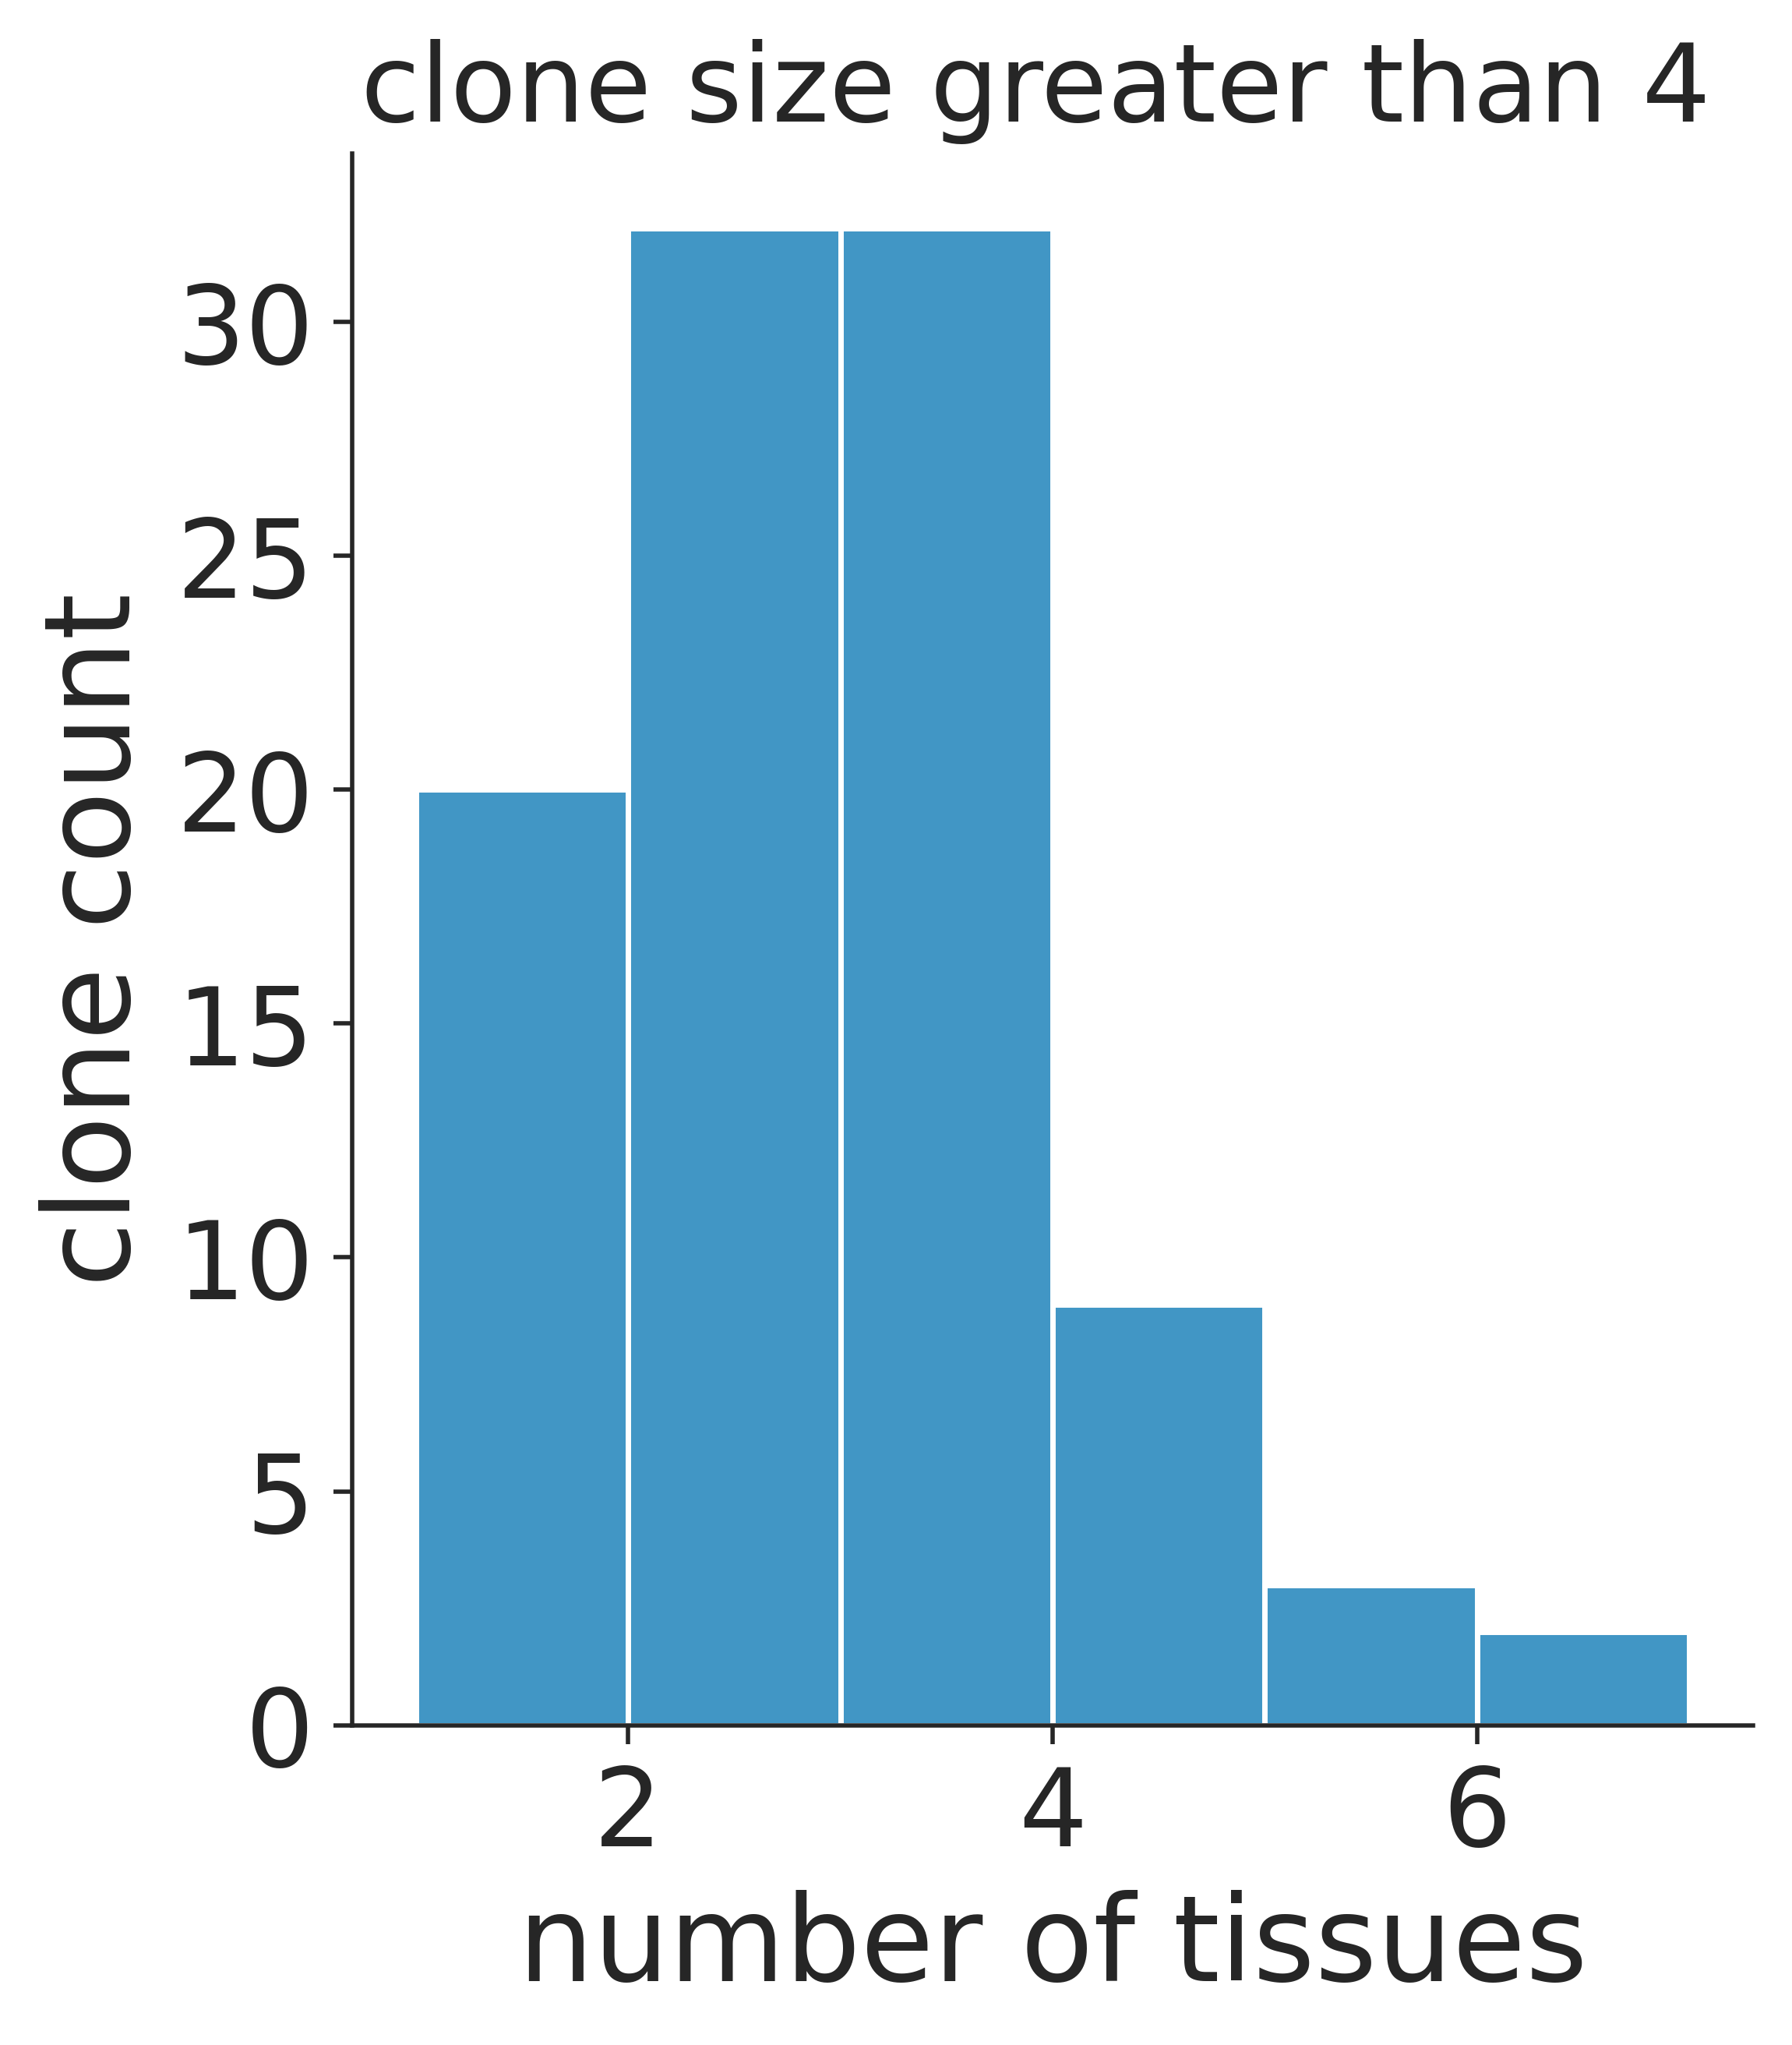

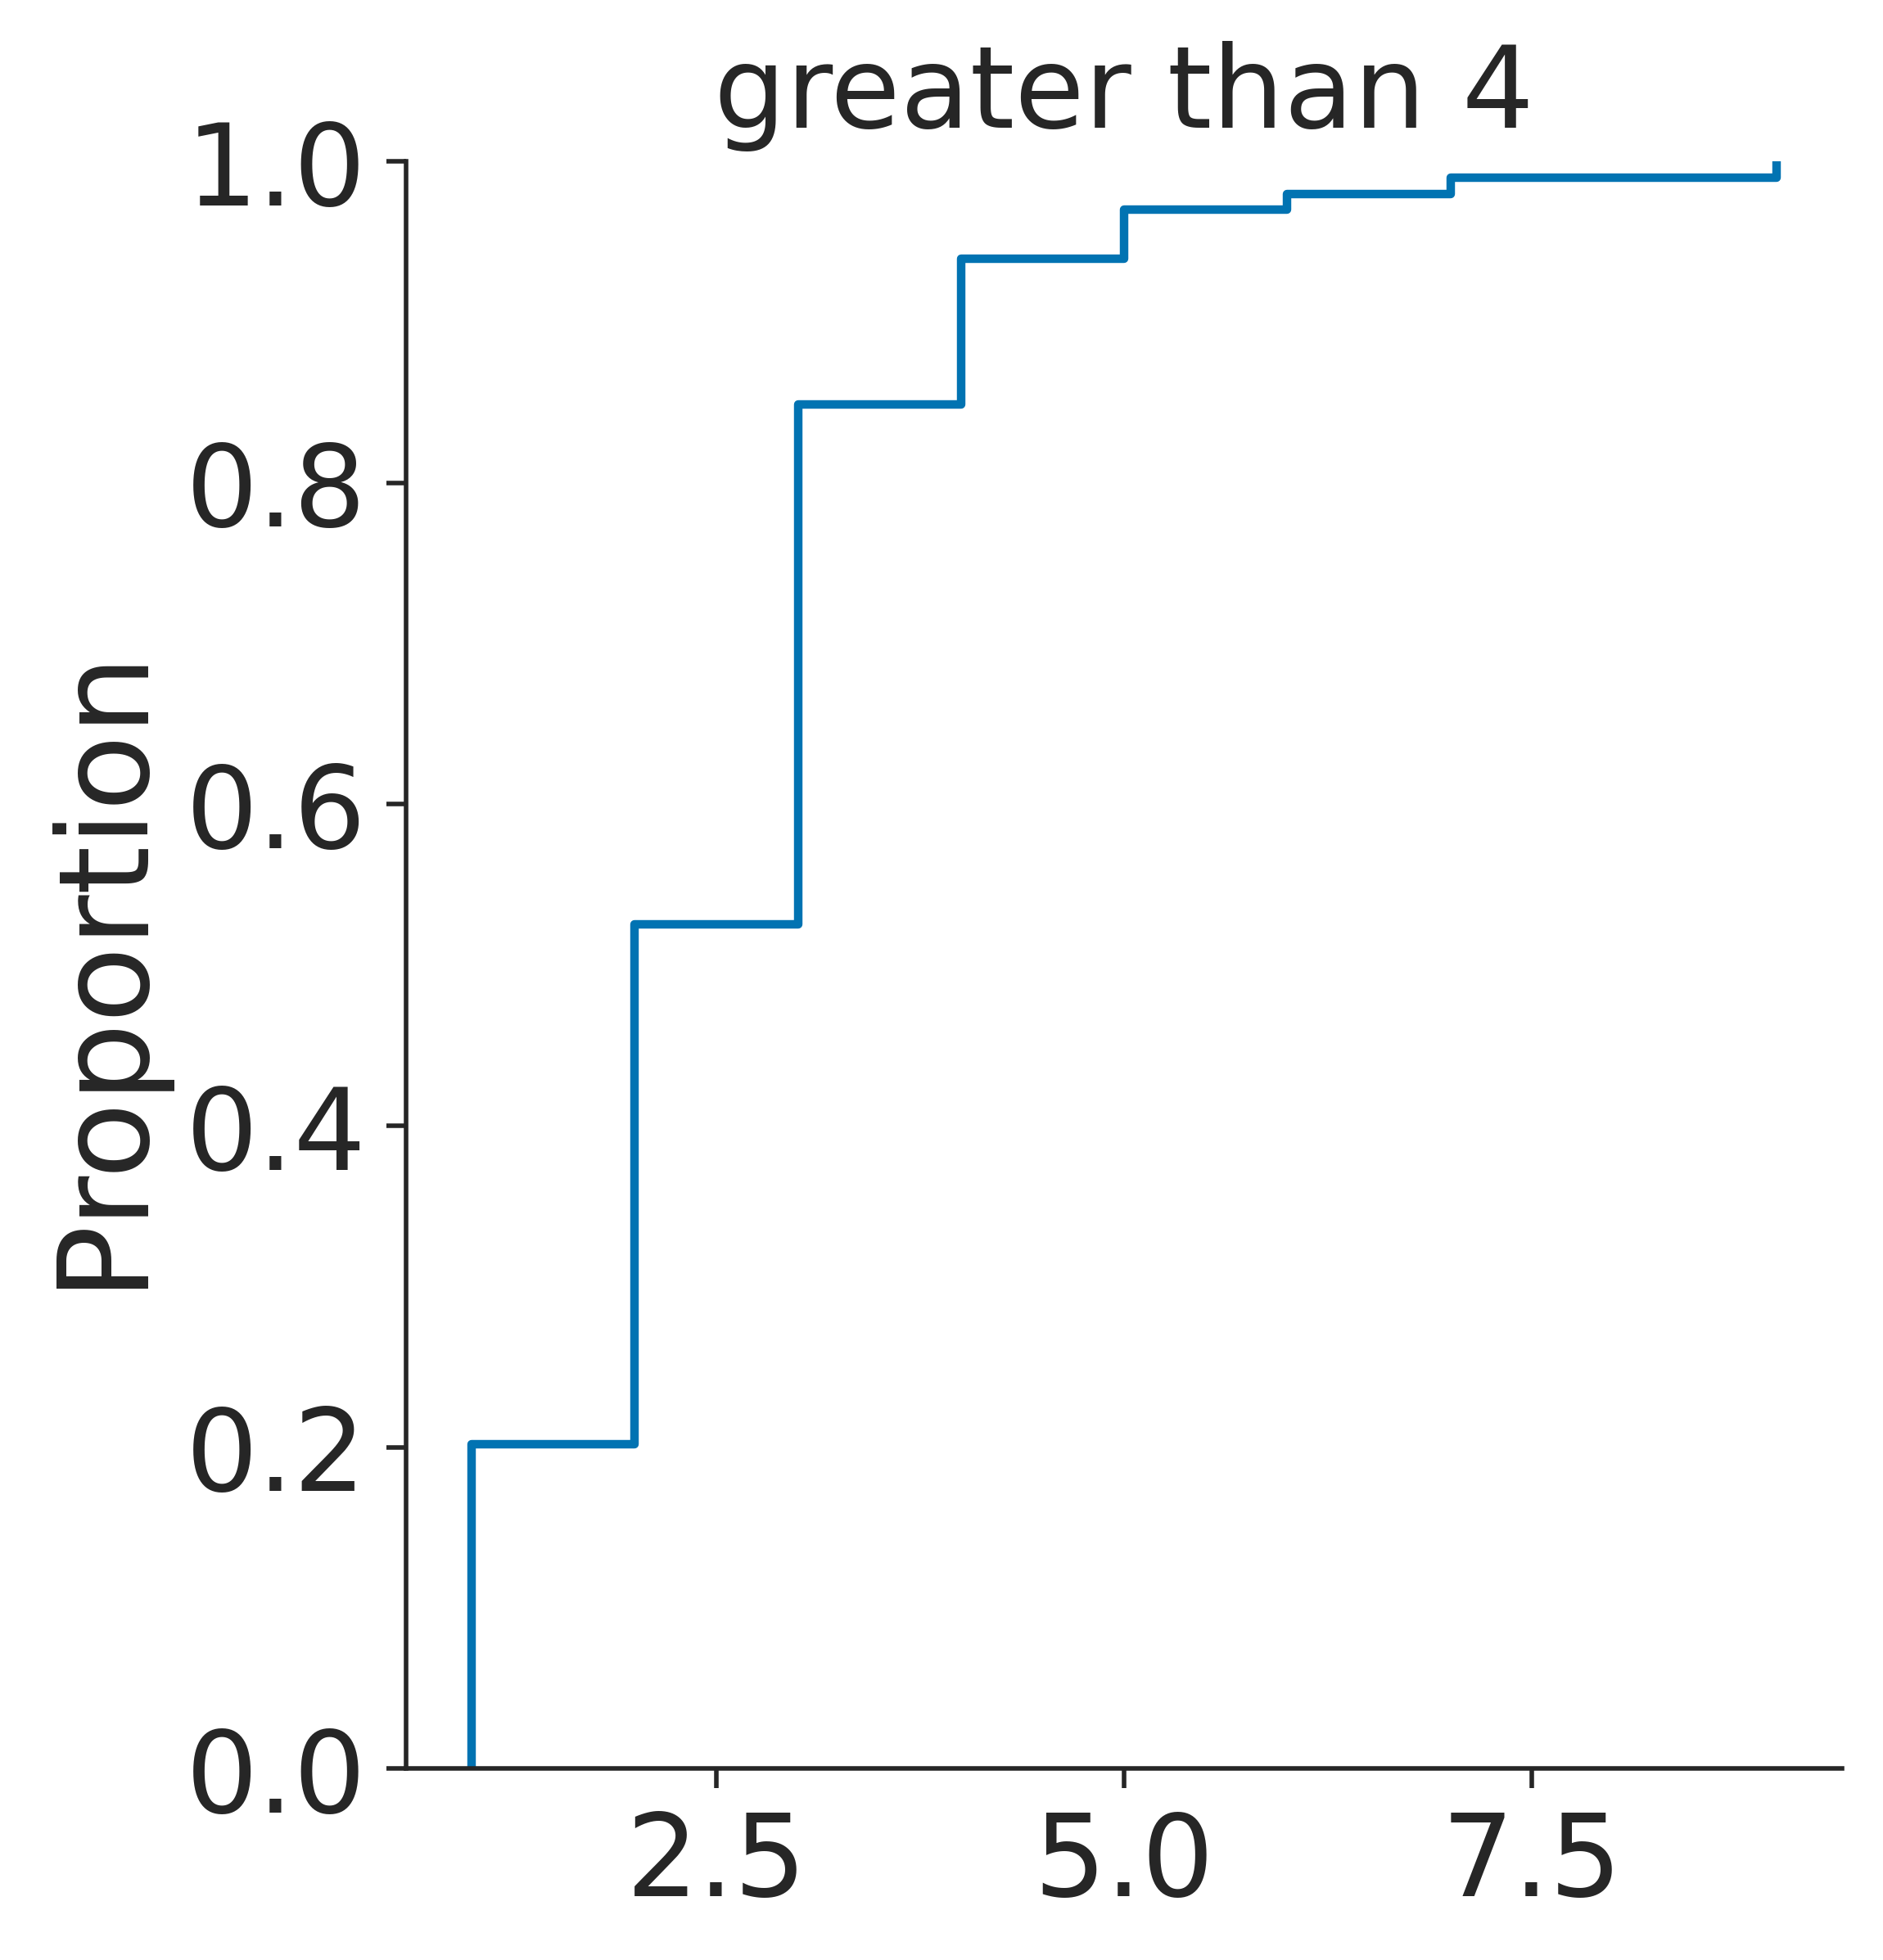

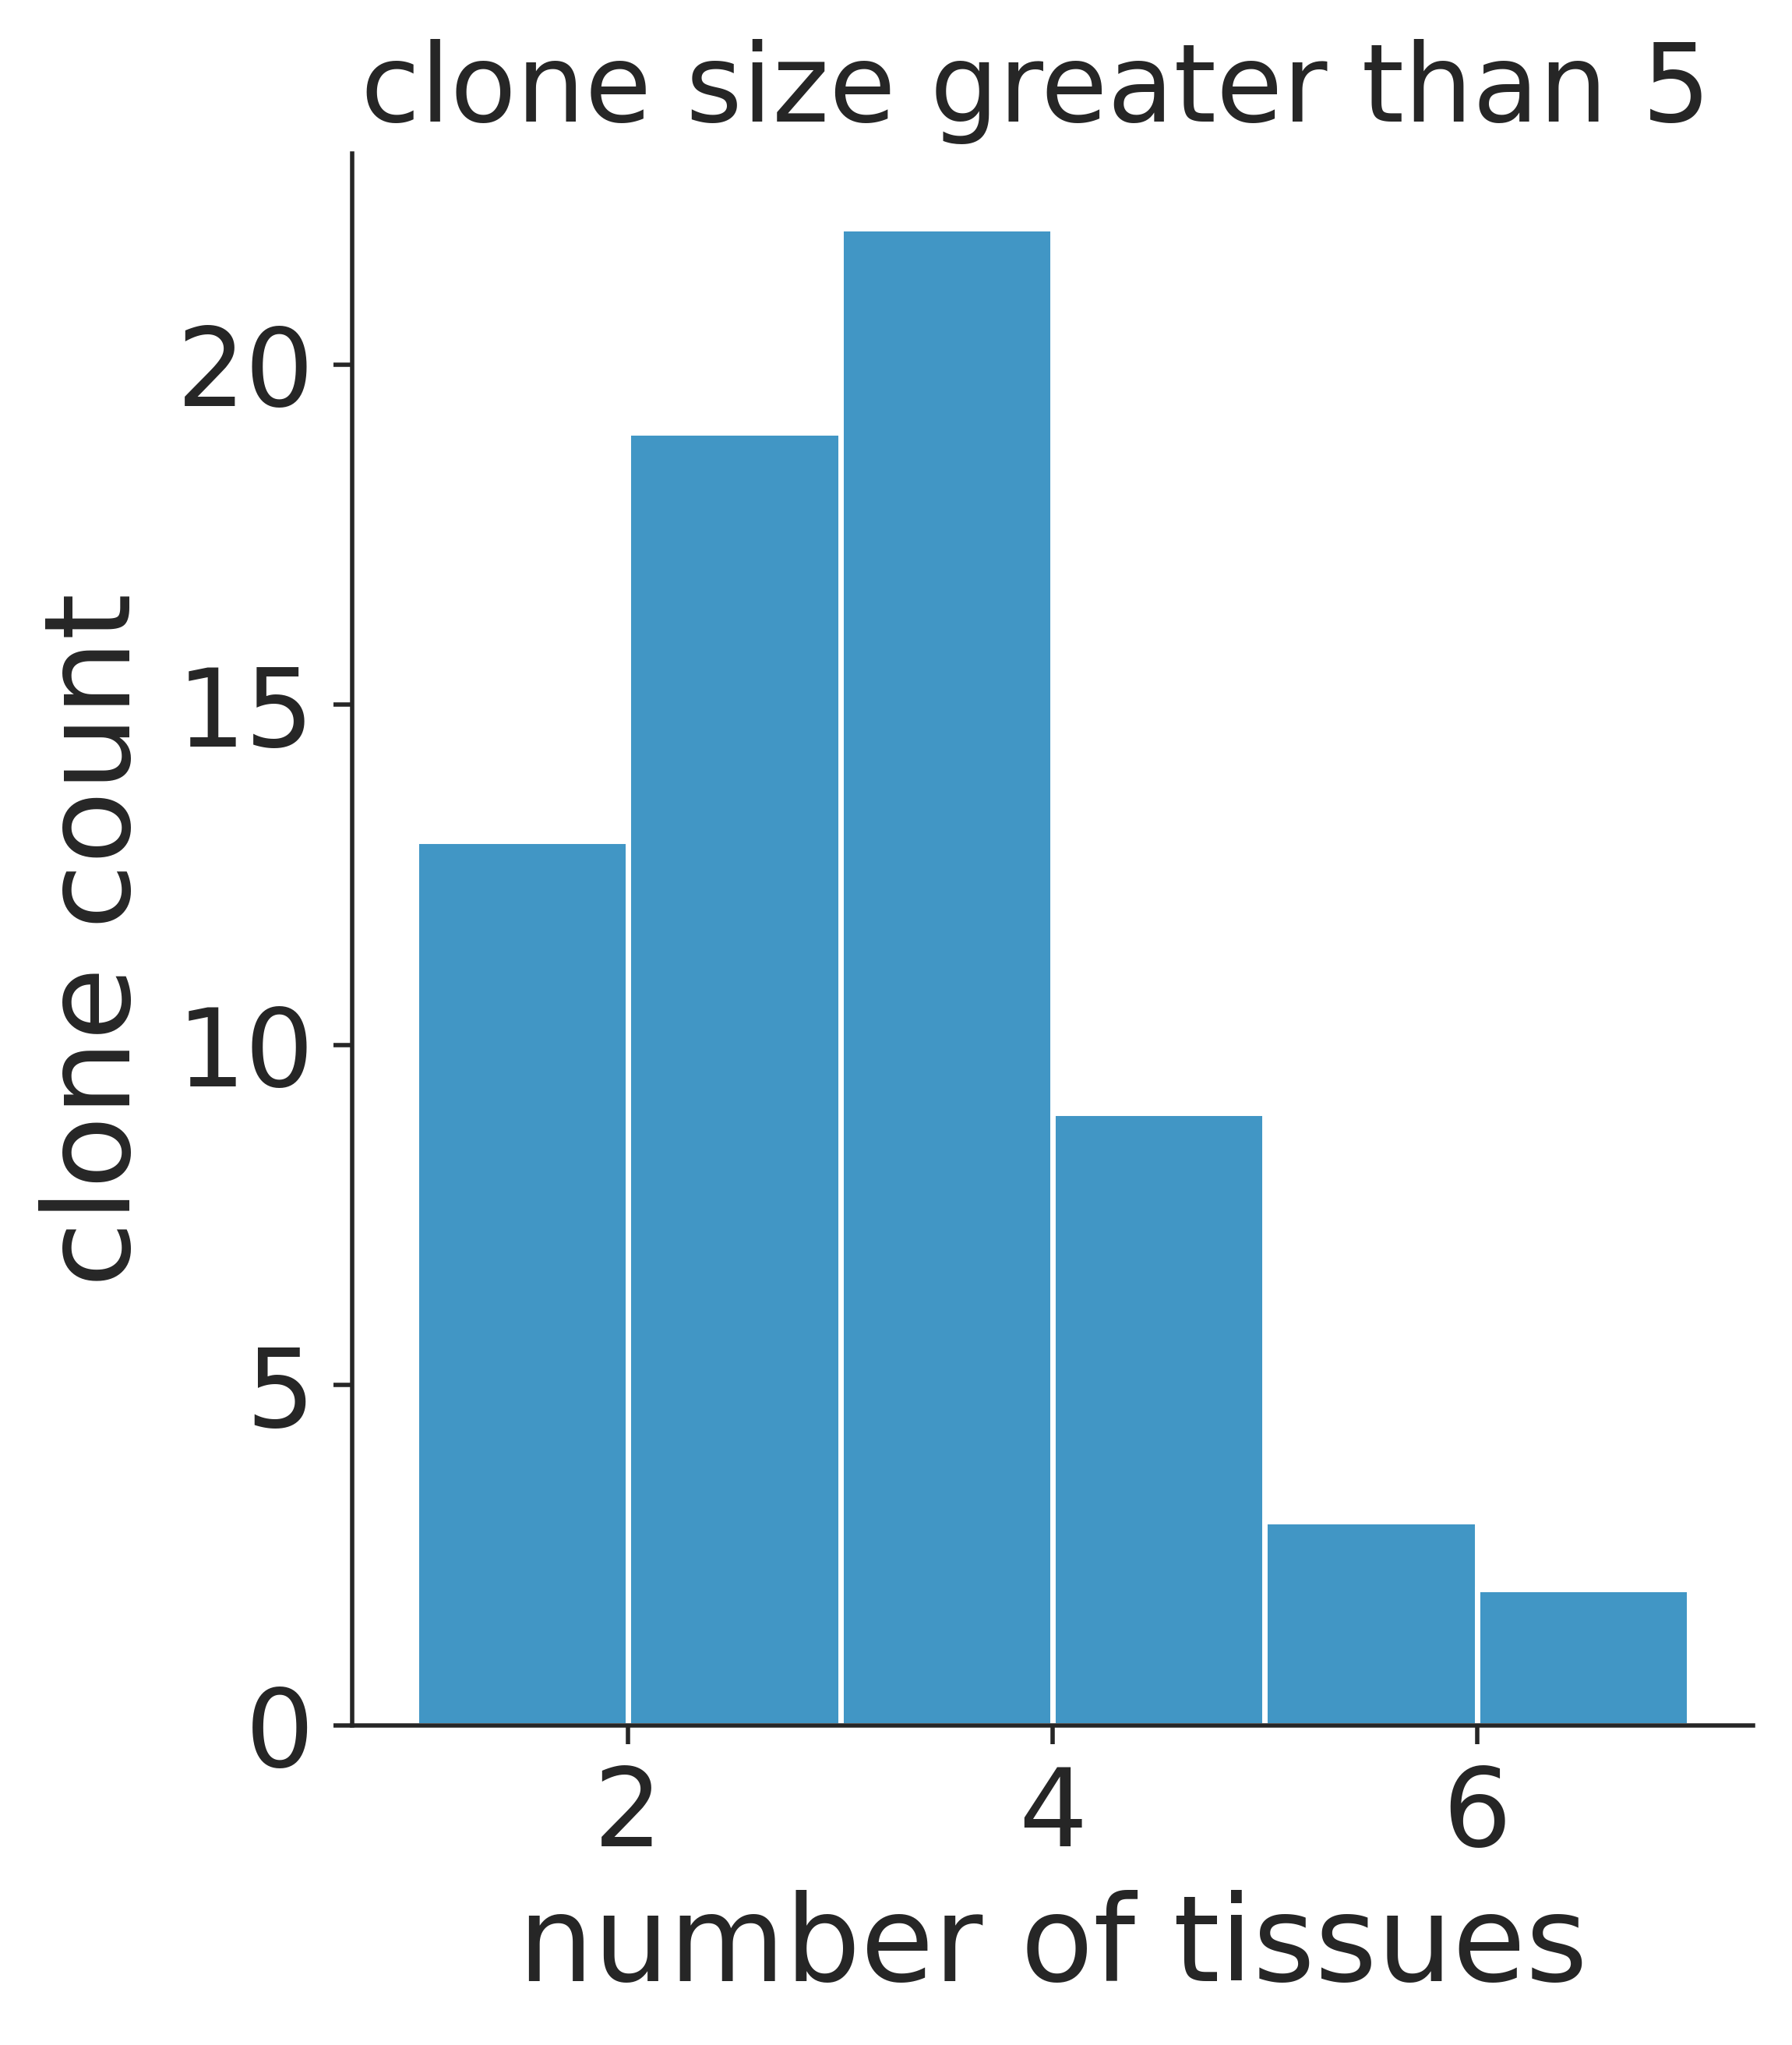

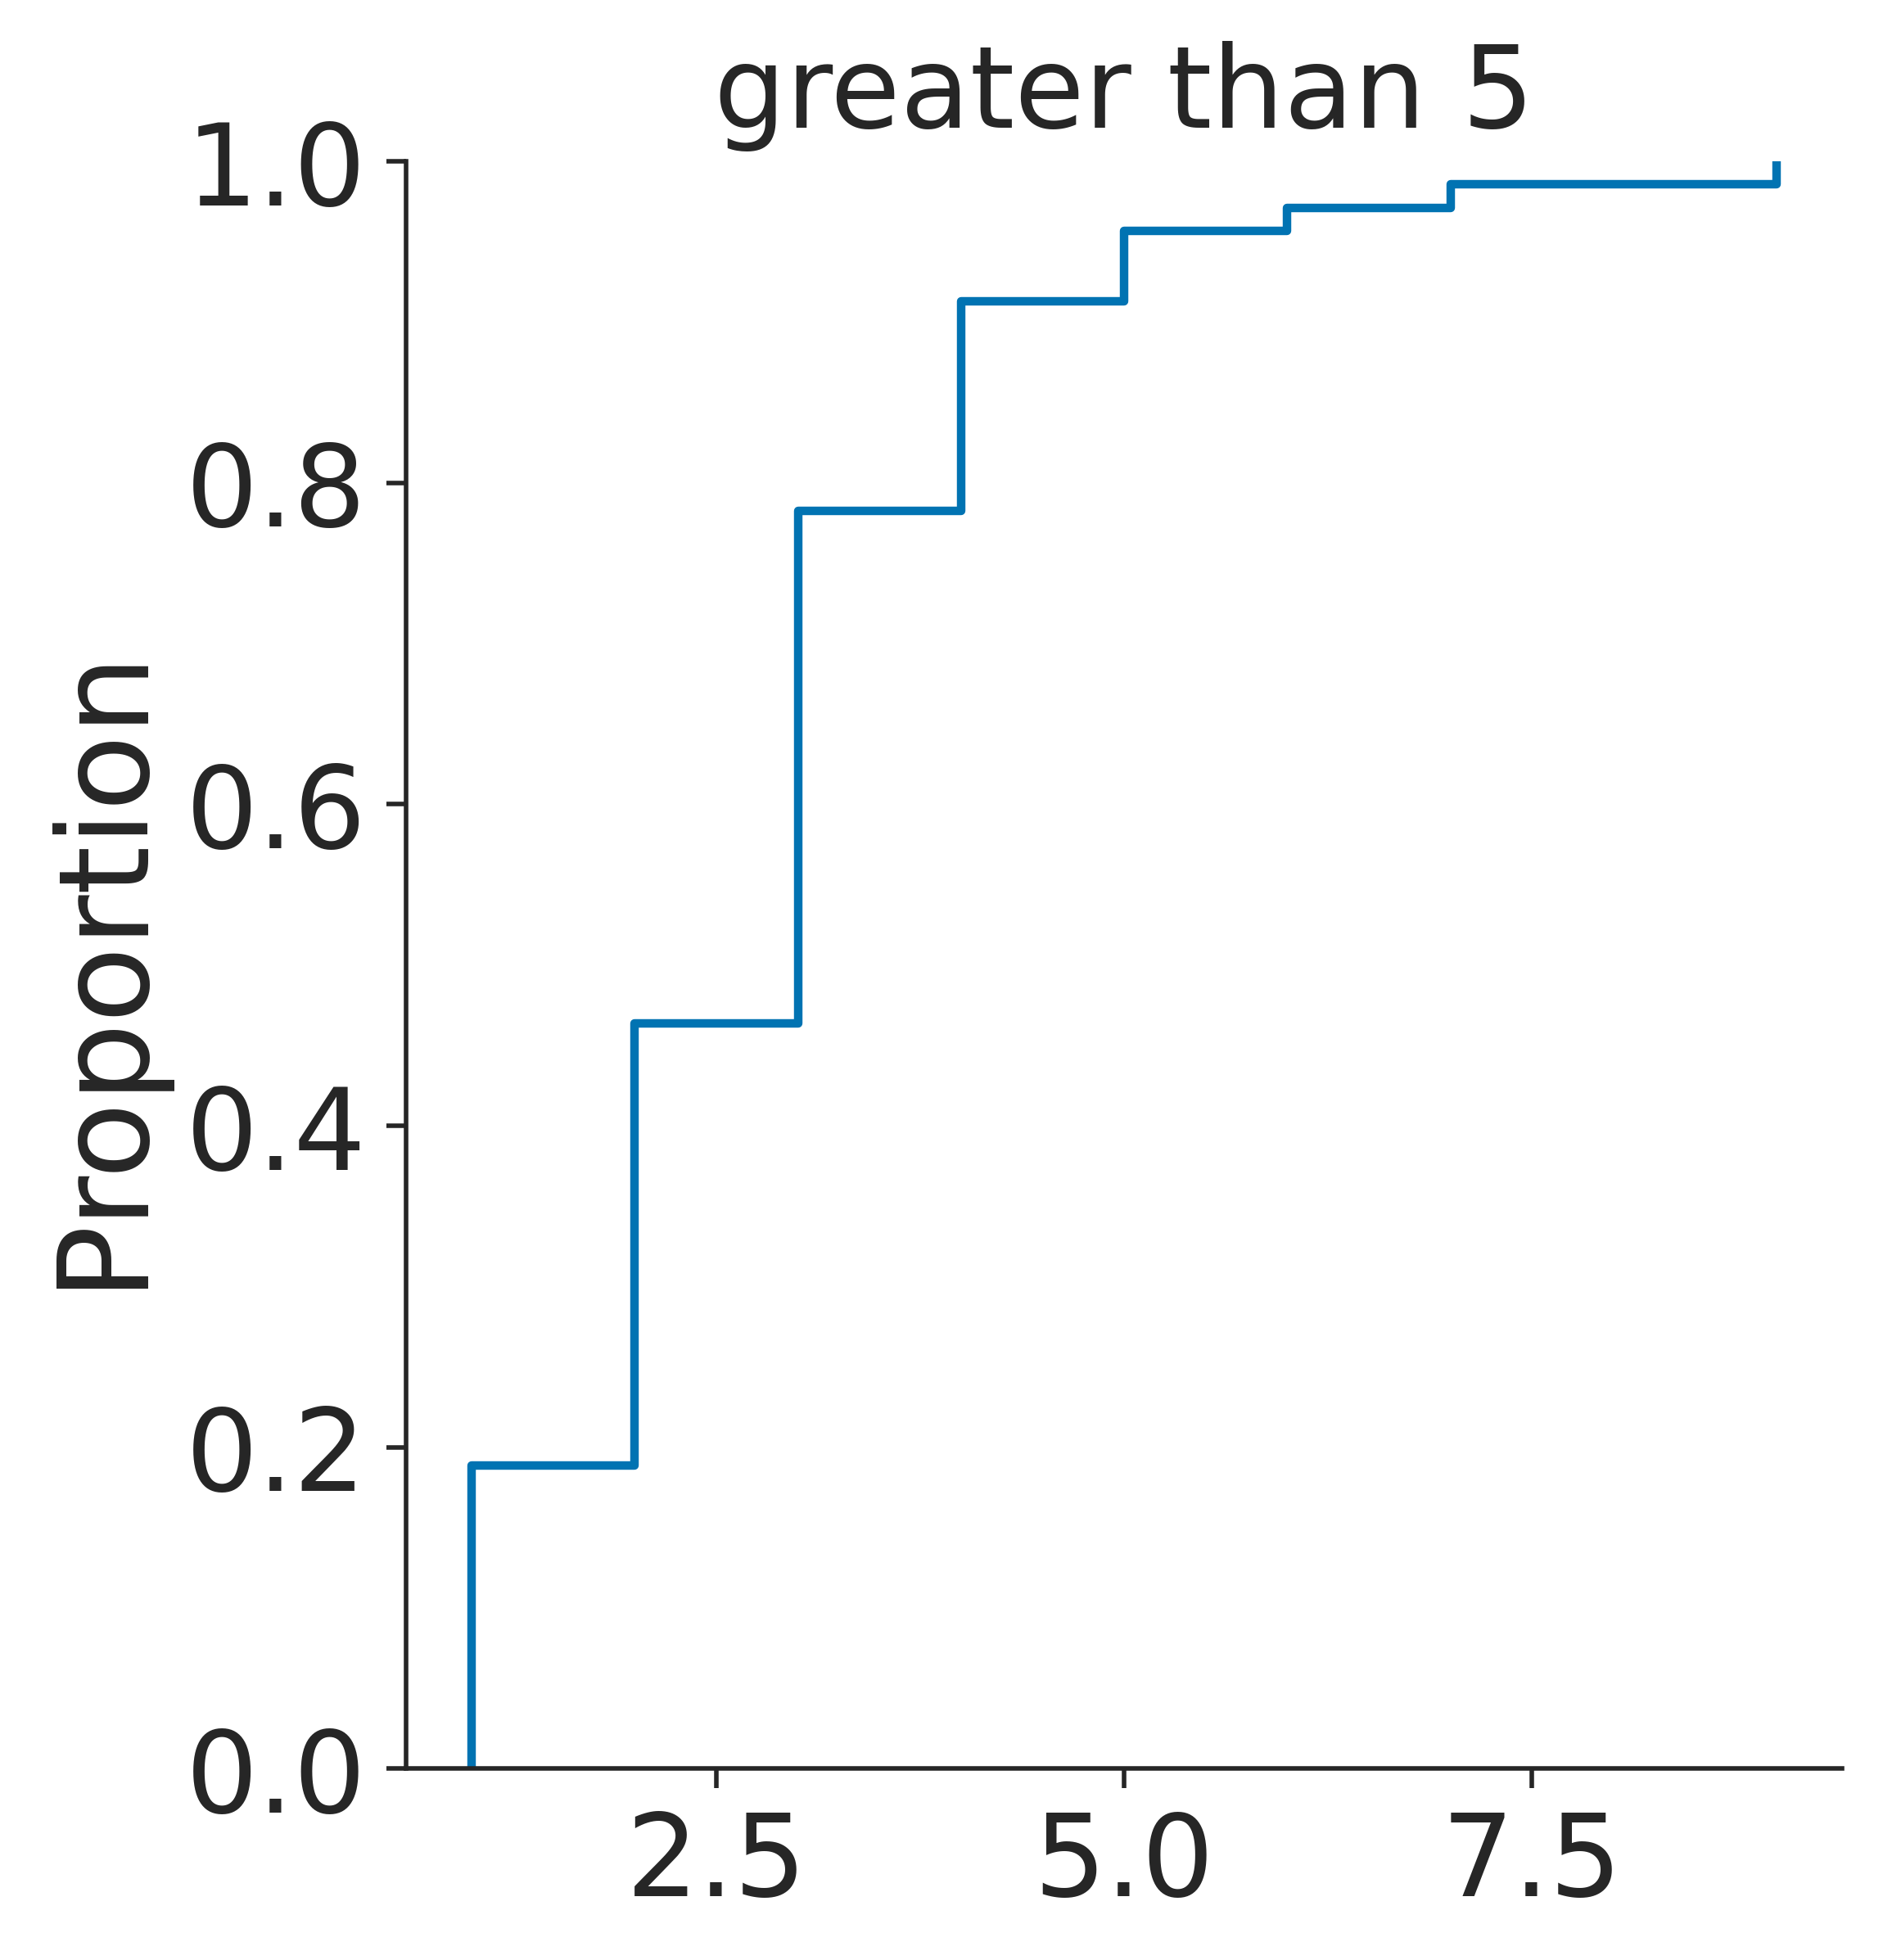

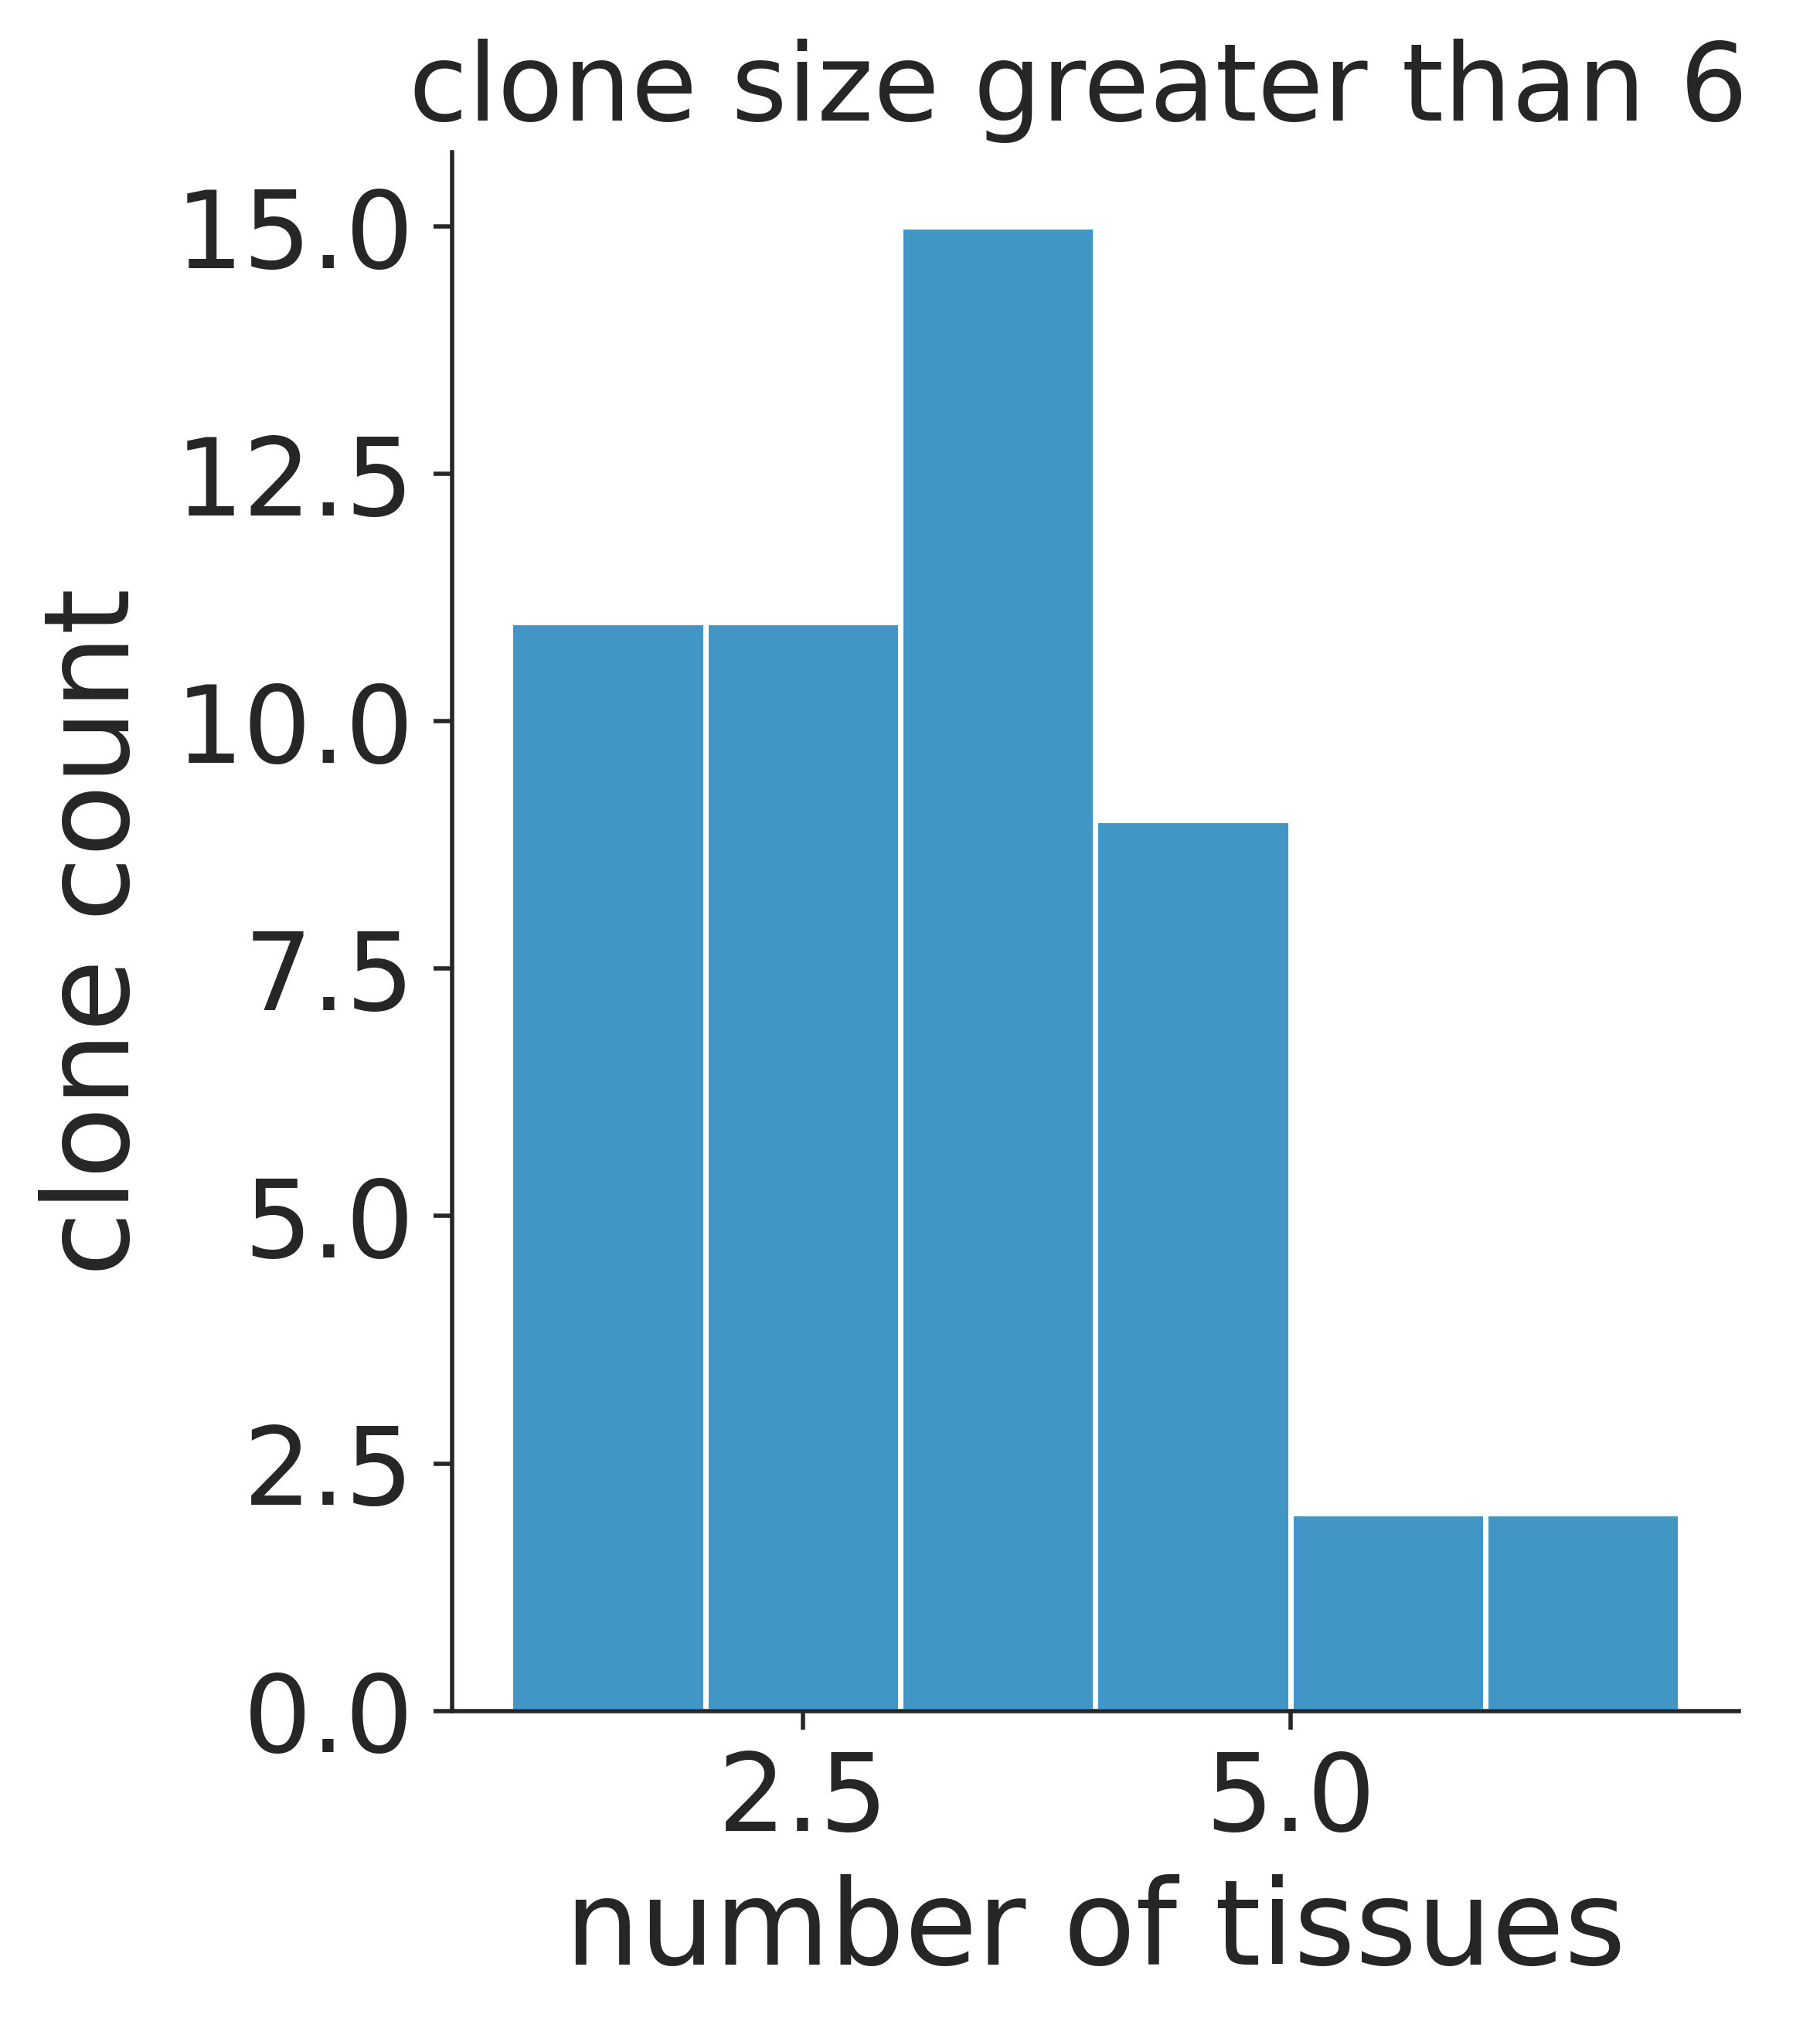

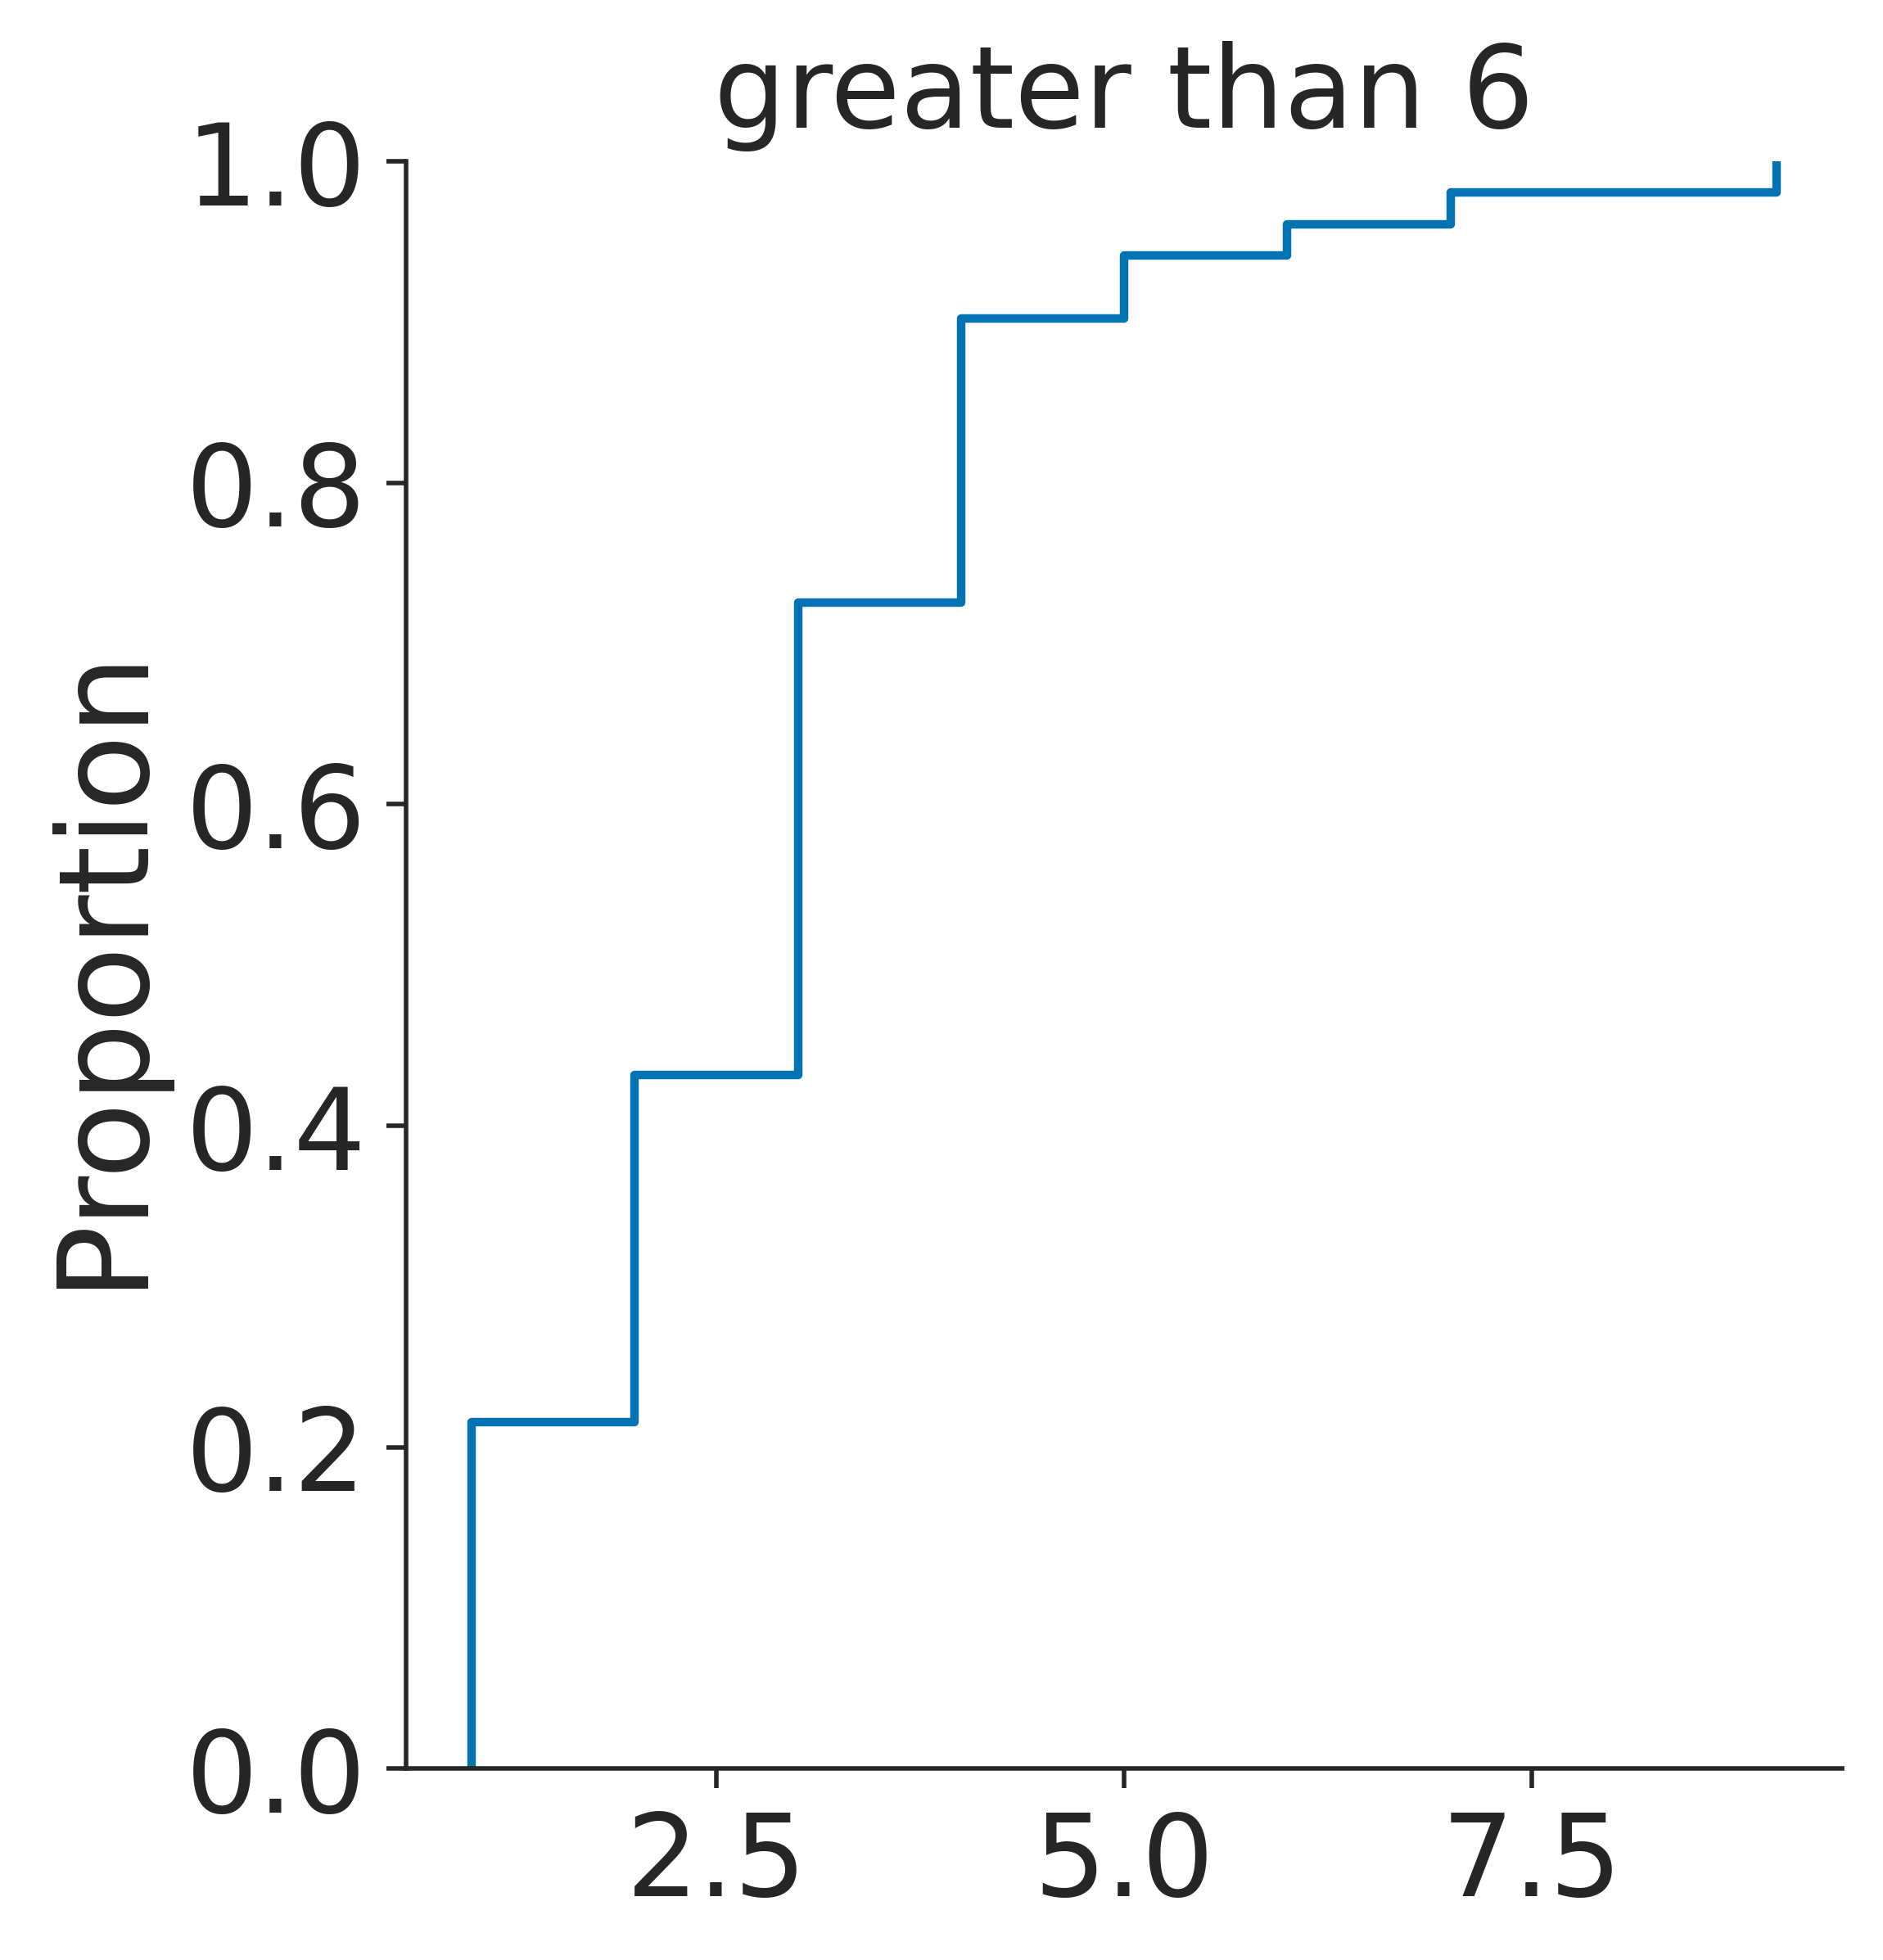

In [93]:
for linsize in [1,2,3,4,5,6]:
    selector = df.lineage.value_counts()
    selector = selector[selector > linsize].index
    _df = df[df.lineage.isin(selector)]
    lin_label = 'lineage'
    label = 'tissue'
    lins = []
    for_hist = []
    for i in _df[lin_label].unique():
        for_hist.append(_df[_df[lin_label] == i][label].nunique())
        lins.append(i)

    g = sns.displot(for_hist, bins = [1,2,3,4,5,6,7])
    plt.ylabel('clone count')
    plt.xlabel('number of {}s'.format(label))
    plt.title('clone size greater than {} '.format(linsize))
    


    g2 = sns.displot(for_hist, kind='ecdf')
    plt.title('greater than {}'.format(linsize))


In [60]:
df[df.lineage == 1716.0]

TSP2    234
Name: donor, dtype: int64

In [57]:
dict(zip(lins, for_hist))

{461.0: 4,
 1808.0: 4,
 1482.0: 2,
 1343.0: 4,
 1344.0: 6,
 928.0: 4,
 1460.0: 6,
 1207.0: 3,
 844.0: 1,
 1019.0: 1,
 1004.0: 2,
 134.0: 2,
 1420.0: 4,
 1971.0: 4,
 1543.0: 3,
 1438.0: 2,
 921.0: 5,
 1011.0: 2,
 460.0: 3,
 514.0: 5,
 1716.0: 6,
 1040.0: 7,
 943.0: 2,
 852.0: 1,
 1767.0: 3,
 1692.0: 2,
 1287.0: 1,
 947.0: 1,
 1347.0: 5,
 1181.0: 4,
 1804.0: 1,
 57.0: 3,
 712.0: 4,
 1109.0: 3,
 781.0: 3,
 38.0: 2,
 1172.0: 4,
 1243.0: 3,
 2185.0: 5,
 851.0: 1,
 2009.0: 3,
 1408.0: 2,
 1940.0: 2,
 329.0: 2,
 1133.0: 2,
 380.0: 3,
 652.0: 4,
 1919.0: 2,
 555.0: 2,
 603.0: 1,
 1464.0: 4,
 528.0: 3,
 1876.0: 2,
 1038.0: 1,
 907.0: 2,
 1984.0: 3,
 939.0: 5,
 435.0: 3,
 1362.0: 2,
 2028.0: 2,
 526.0: 2,
 417.0: 1,
 1005.0: 3,
 1298.0: 3,
 1468.0: 2,
 1867.0: 3,
 26.0: 1,
 885.0: 1,
 290.0: 2,
 442.0: 1,
 1280.0: 2,
 401.0: 4,
 664.0: 1,
 531.0: 1,
 645.0: 2,
 1139.0: 2,
 1210.0: 4,
 1263.0: 4,
 1665.0: 2,
 2211.0: 1,
 476.0: 3,
 341.0: 1,
 741.0: 1,
 2119.0: 1,
 1098.0: 1,
 1708.0: 1,
 824.0: 

In [48]:
g.savefig(output_dir+'TCR_clones_by_tissue_hist')

# counting multi-donor TCRs

Text(0.5, 122.222222222222, 'number of donors')

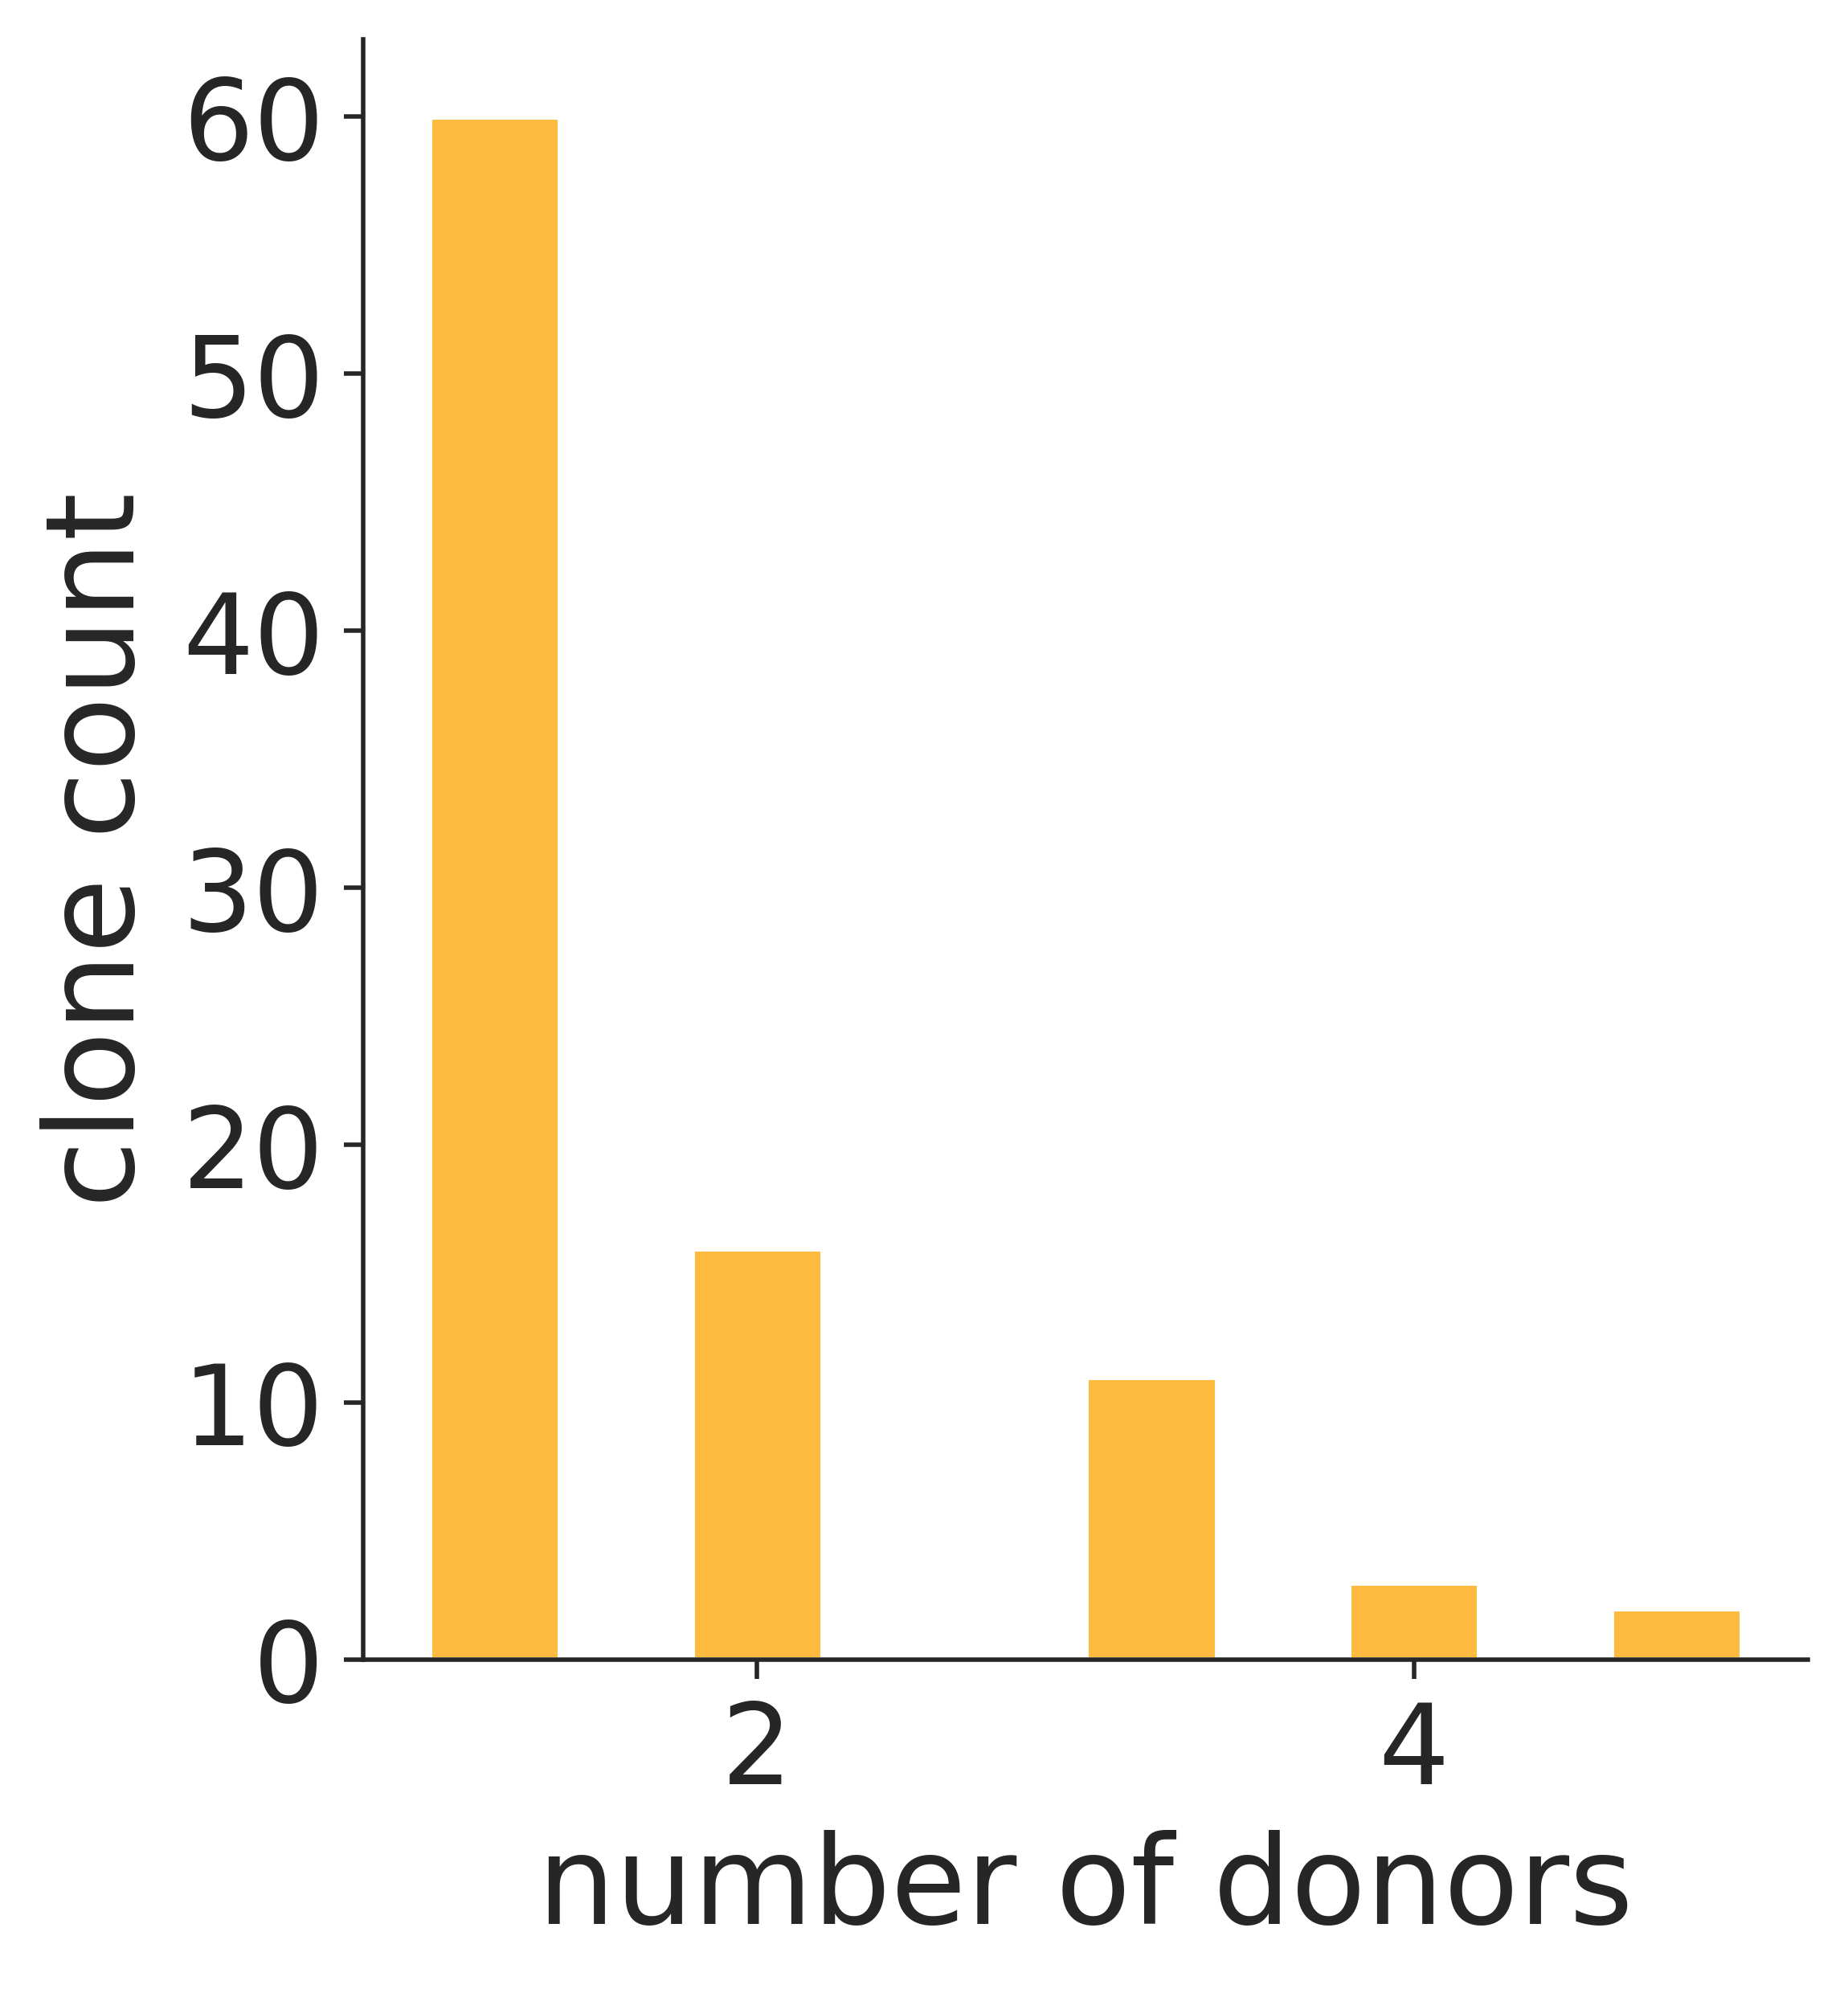

In [51]:
lin_label = 'lineage'
label = 'donor'

for_hist = []
for i in df[lin_label].unique():
    for_hist.append(df[df[lin_label] == i][label].nunique())

g = sns.displot(for_hist, color = 'orange')
plt.ylabel('clone count')
plt.xlabel('number of {}s'.format(label))

In [52]:
g.savefig(output_dir+'TCR_clones_by_donor_hist')